In [1]:
import os
from tqdm import tqdm
import numpy as np
from functools import partial
from scipy.optimize import fsolve

import rebound
import astropy.units as u
import astropy.constants as ast

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# Administrative functions and information for plotting and data management
def setup_plot(sizeTuple, logscale=1):
    cmap = plt.get_cmap('copper')

    matplotlib.rcParams.update({'font.size': 25}) #adjust font
    matplotlib.rcParams['axes.linewidth'] = 2.0
    fig = plt.figure(figsize=sizeTuple) #adjust size of figure
    ax = plt.axes()
    ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
                   width=2)
    ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
                   width=2)

    if logscale==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
    elif logscale==2:
        ax.set_xscale('log')
    elif logscale==3:
        ax.set_yscale('log')

    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    return cmap,fig,ax

# Useful Constants
const ={
    'G' :  6.67430e-11, #SI
    'R_b' : 0.0677, #AU
    'R_c' : 0.1189 , #AU
    'R_d' : 0.1662, #AU
    'R_e' : 0.2138, #AU
    'R_f' : 0.2535, #AU
    'P_b' : 5.7, # days
    'P_c' : 13.2, # days
    'P_d' : 21.8, # days
    'P_e' : 31.8, # days
    'P_f' : 41,# days
    'M_b' : 3.68, #Earth
    'M_c' : 0.39, #Earth
    'M_d': 3.91, #Earth
    'M_e' : 5.57, #Earth
    'M_f': 9.6, #Earth
    'AU' : 1.496e11, #m
    'M_star' : 1.29, # solar mass
    'M_sun' : 1.988e30, # kg
    'day_to_sec' : 86400,
    'M_earth' : 5972e24, #kg
    'M_earth_sun' : 3e-6 # solar masses
}

# Getting the current working directory and the path to the data.
currDir = os.getcwd()

We are modelling the system of Kepler 33, which has five planets, sublabelled 'b', 'c', 'd', 'e', 'f'.

# Handling and Formatting the Transit Timings from Kepler 33

### 1. Getting the needed data for TTVs - Setting inital parameters

In [3]:
conNum = lambda arr, idx: np.array(arr, dtype=object)[idx]

def get_transitTimingData(path):
    '''
    Extracting the timing data. One column gives the predicted transits and the other gives
    the predicted minus the observed, and the last one gives the errors in timings. The data
    file is organized as follows:
    Column 1: Period - considered to be constant (P)
    Column 2: Extra time in Period that is not expected due to TTV (pred)
    Column 3: Error in data
    '''
    # Period prediction, Period values with TTVs, Errors
    predArr, t0Arr, errArr = [], [], []
    
    # Load in the data - These are taken from Prof Rowe notes
    for file in os.listdir(path):
        d = np.loadtxt(path+'/'+file)
        
        predArr.append(d[:, 0])
        t0Arr.append(d[:, 0] + d[:, 1]) # Adding period value + TTV values
        errArr.append(d[:, 2])
    
    # Find the period of the data to determine which data file
    # corresponds to which planet and set up our arrays in the order of b, c, d, e, f
    P = np.array([np.min(arr[1:] - arr[:-1]) for arr in predArr])
    
    # We sort by the period (ie. each period corresponds to a specific planet)
    # because the data files are not in order. 
    sIdx = np.argsort(P) # Index of the files in ascending period value
    
    P_ordered = P[sIdx] # Period in order -> b, c, d, e, f
    
    # All data arrays in the order of the planets
    predArr_ordered = conNum(predArr, sIdx)
    t0Arr_ordered = conNum(t0Arr, sIdx)
    errArr_ordered = conNum(errArr, sIdx)
    
    return P_ordered, predArr_ordered, t0Arr_ordered, errArr_ordered

In [4]:
# Getting the data - Period, Predicted Period, Period+TTV, Error 
P, pred, t0, err = get_transitTimingData(currDir + '/koi707_timing')

### 2. Setting a time zero

We want to start the data at the first recorded TTV. So, we are finding the smallest inital time value out of all the planets and taking it to by our 'time zero'. The other planets will have an offset determined by the extra time before a TTV is recorded. This initial position is described by an angular distance position called 'f'.

In [5]:
# Finding the smallest inital time value
tranTime1 = np.array([arr[0] for arr in pred])
minTran = np.min(tranTime1)
b4T0 = tranTime1-minTran # Extra time for each planet
# Deriving the maximum time elapsed within the data. 
totTime = np.max([np.max(t0Arr) for t0Arr in t0]) - minTran
bufferTime = totTime + np.max(P) # Time for an orbit of our longest planet.
totYears = (bufferTime*u.day).to(u.year)

# Orbital Elements

### 1. Setting up our initial conditions

Parameters we are using: Mass (m), Eccentricity (ecc), Period (P), True anamoly (f). The only value that is left to calculate is f. The inital condition are set up according to previously stated article.

In [6]:
def getEccentric(x, e, M):
    '''
    to solve for the eccentric anomaly
    '''
    return x - e*np.sin(x) - M

def fCalc(b4T0, P, e):
    '''
    To approximate the starting positions. First, we find the mean ananomaly, taking T0 as periapsis.
    Then, we derive the eccentric ananomaly by solving the equation given in getEccentric. We then directly
    derive our true ananomaly from our eccentric ananomaly, given as the alternate form from
    https://en.wikipedia.org/wiki/True_anomaly.
    '''
    M = 2*np.pi*(P - b4T0)/P # this our mean anomaly 
    fArr = np.zeros((5,))
    
    for i, mi in enumerate(M):
        eccen = partial(getEccentric, e=e[i], M=mi) 
        E = fsolve(eccen, 0.6)[0]
        # The calculation to derive the true anomaly from the eccentric anomaly.
        beta = e[i]/(1+np.sqrt(1-e[i]**2))
        temp = beta*np.sin(E)/(1-beta*np.cos(E))
        fArr[i] = E + 2*np.arctan(temp)

    return fArr


# Eccentricity
ecc = np.array([0.2, 0.05, 0.03, 0.02, 0.02])/3
f = fCalc(b4T0, P, ecc) # Initial position
print(f)

[5.85272792 0.51388006 2.10511176 5.41825646 6.28318531]


In [7]:
# System Parameters
# Units of the REBOUND system are Solar Masses, Rad and Days

System = {
    'Names': ['b', 'c', 'd', 'e', 'f'],
    'Mass' : np.array([3.68, 18.3, 7.5, 6.6, 8.2])*(ast.M_earth/ast.M_sun).value, # Solar masses
    'Period' : P, # Days
    'Ecc': ecc, # No units
    'Inc': np.array([np.pi/2]*5), # Rad
    'f_true': np.array(f), # Rad
    'colours': np.array(['tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'])
}

# Rebound

In [8]:
def solve_nBody(orbE, length_integration=(totYears.value)):
    '''
    Set up our system, choosing our integrator and adding our star. Subsequently, we can populate the simulation
    with planets. We use Rebound to solve for the positions of our planets, thus solving the 5 body system. 
    Note that generally, orbE == System as defined in the cell above. Rounding up for the length of time the
    simulation will run.
    '''
    # Set up the system initial positions
    kep33 = rebound.Simulation() 
    kep33.integrator = 'IAS15'
    
    # Our star is at the centre of the system with no velocity etc, so no orbital elements for it except mass.
    kep33.add(m=1.26) # The units are in solar masses.
    
    # Populating the simulation with our planets. 
    for i in range(len(orbE["Names"])):
        # Plugging in our orbital parameters.
        kep33.add(m=orbE['Mass'][i], P=orbE['Period'][i], e=orbE['Ecc'][i], inc=orbE['Inc'][i], f=orbE['f_true'][i])
 
    # Moving our system to the centre of mass frame, which should be in the star
    kep33.move_to_com() 
    kep33.dt = np.min(orbE['Period'])/20 # maximum step size in our integrator   
    
    # Information 
    times = []
    exoPos = {
        'star': [],
        'b': [],
        'c': [],
        'd': [],
        'e': [],
        'f': []
    } 
    
    # intial time of the simulation
    initial_time = kep33.t
    
    while kep33.t - initial_time < 365.25 * length_integration:
        # append the times 
        times.append(kep33.t)
        
        # append x, y, z position for the star and each planet, as our orbit is in the x-z plane. 
        for i in range(len(exoPos)):
            planet = kep33.particles[i]
            # As the star is not in our system dictionary.
            if i == 0:
                exoPos['star'].append([planet.x, planet.y, planet.z])
            else:
                exoPos[orbE['Names'][i-1]].append([planet.x, planet.y, planet.z])

        # Integrate forward by one step, the step size is adapted by the integrator
        kep33.integrate(kep33.t + 0.01)
        # the integrator chooses an adaptive step size

    return exoPos, times

In [23]:
class Orbit:
    def __init__(self, planet_path):
        self.x = planet_path[:, 0]
        self.y = planet_path[:, 1]
        self.z = planet_path[:, 2]

def get_orbits(planet_positions):
    '''
    Converts values from nbody solver to orbit objects
    '''
    orbits = []
    
    planet_positions['star'] = np.array(planet_positions['star'])
    star_orbit = Orbit(planet_positions['star'])

    for i in range(len(planet_positions)-1):
        planet_positions[System['Names'][i]] = np.array(planet_positions[System['Names'][i]])
        orbits.append(Orbit(planet_positions[System['Names'][i]]))
        
    return star_orbit, orbits


def get_model(planets, adjusted_pars, properties):
    """
    Input: the names of the planets, the parameters that have been adjusted and which parameter has been adjusted
    
    Output: An array of the star position, array of orbits of each planet, times array
    
    Example usage:
    function(['a','b'], [[2,6],[3,4]], ['Mass','Period'])
    """
    for p, planet in enumerate(planets):
        index = System['Names'].index(planet)
        for i, prop in enumerate(properties):
            (System[prop])[index] = adjusted_pars[p][i]

    planet_positions, times = solve_nBody(System)
    star_orbit, orbits = get_orbits(planet_positions)
    return star_orbit, orbits, times

# Aligning Our Simulation to Observations

### 1. Getting Transit Times from the N-Body simulation

This is the data that will be used to compare in our MCMC code to determine if the parameters are a good fit.

In [24]:
def getTransits(x, y, time):
    '''
    With our (x,y) position from the data, we want to be able to find where the transits are. This allows us
    to compare our findings to the data. Define the transit to be at y=0 in the axis on the right (x positive).
    '''
    # What are referred to as y are z values as we use a pi/2 inclination, so x-z plane orbit.
    t_transit = []
    
    # First, we check if we have a y=0 solution at a positive x value 
    # If that is the case, the planet is at the right position for it to be transiting
    if len(np.where(y == 0)[0]) != 0:
        zeroMask = np.logical_and(x>=0, y==0)
        indices = np.arange(len(y))[zeroMask]
        for idx in indices:
            # Adding time according to index
            t_transit.append(float(time[idx]))
        
    else:
        # Getting array where y value changes sign
        index = np.where(np.diff(np.sign(y)))[0] 

        for i in index:

            if np.abs(x[i]) == x[i]: # Verifying if x is positive
                
                if i == len(index):
                     t_transit.append(time[i])
                else:
                    # Taking proportion to interpolate time value at y=0
                    diff = np.abs(y[i]-y[i+1])
                    prop = np.abs(y[i])/diff
                    new_dt = prop*(time[i]-time[i+1])
                    t = time[i]+new_dt #Time at index and additional time
                    t_transit.append(float(t))  
                    
    return np.sort(t_transit) # Making sure the time is in ascending order

def systemTransits(orbPars):
    '''
    Input: Orbital parameters to be changed by MCMC (array of arrays) 
    Output: Array of arrays of transit times
    
    We compute the simulation and get our transit times from this
    '''
    # What we identify in here is what will change in the function - NEED TO MODIFY ACCORDING TO WHAT CHANGES
    # orbPars = [[],[],[]] -> [b, c, d]
    star_orbit, p_orbit, times = get_model(['b', 'c', 'd', 'e', 'f'], orbPars, ['Period', 'Mass', 'Ecc', 'f_true'])
    transits = []
    times = np.array(times)
    
    # Loop through each simulated orbit, so we compute the transits for each of the planets. 
    for orbit in p_orbit:
        tPlanet = getTransits(orbit.x, orbit.y, times)
        transits.append(np.array(tPlanet))
        
    return np.array(transits, dtype=object)

### 2. Correction to data before running the MCMC

In [11]:
def padObs(t0, pred, period):
    '''
    Where we add zero values to where the difference is not the period, which is given by our predicted array.
    '''
    pDiff = pred[1:] - pred[:-1]
    pGreater = pDiff - period >= 10**-4
    # Because sometimes there is more than one transit skipped, so they must be counted. 
    numZeros = np.array(pDiff[pGreater]//period - 1, dtype=int)
    # This is the first index where we need to insert a zero value into. 
    insertStartIdx = np.where(pGreater)[0] + 1
    insertIdx = np.array([], dtype=int)
    
    # We need to 'pad' out the insertIdx array to reflect the number of values to insert.
    for i, numZero in enumerate(numZeros):
        insertIdx = np.append(insertIdx, np.tile(0, numZero) + insertStartIdx[i])
    t0Corr = np.copy(t0)
    # Insert the value at the desired positions but as the array shifts, we need to enumerate.
    for i, idx in enumerate(np.array(insertIdx, dtype=int)):
        t0Corr = np.insert(t0Corr, idx+i, 0)  # Insert 0 behind the original value
        
    return t0Corr, np.where(t0Corr == 0)[0]

def matchTime(simT0, padT0Idx, n):
    '''
    Remove the values where there is a zero in padT0 (the padded observed T0 values) and there is not
    in simT0, and then truncate our simT0 array if necessary.
    
    padT0Idx: the indices where there are zero values in our padT0 array.
    simT0: our simulated transit times. 
    '''
    if len(simT0) < padT0Idx[-1]:
        return simT0[:n]
    
    removed = np.delete(simT0, padT0Idx)
    return removed[:n]

In [12]:
# We correct our observational data in order to match it to the model values here.
t0Corr, zeroIndices  = [], []

for i in range(len(System['Names'])):
    
    # Handling the padding situation. 
    _, idx = padObs(t0[i], pred[i], P[i])
    zeroIndices.append(idx)
    # Subtracting the initial offset that the model utilises to properly set up the system.
    t0Temp = np.copy(t0[i]) - minTran
    t0Corr.append(t0Temp)
    
t0Corr = np.array(t0Corr, dtype=object)
# Thus, we can define our data as:
data = (t0Corr, err)
# And we write the zero indices to the System dictionary because we use it in the MCMC algorithm
System['ZeroIndices'] = np.array(zeroIndices, dtype=object)

## Testing it Out!

### an example of our simulation run 
Running the REBOUND simulation, which shows that our orbits are as expected! Our orbits are in the x-z plane.We use the best parameters that we have, i.e. those from Sikora et al. (2022). 

### calculating and comparing our transit times with the observations

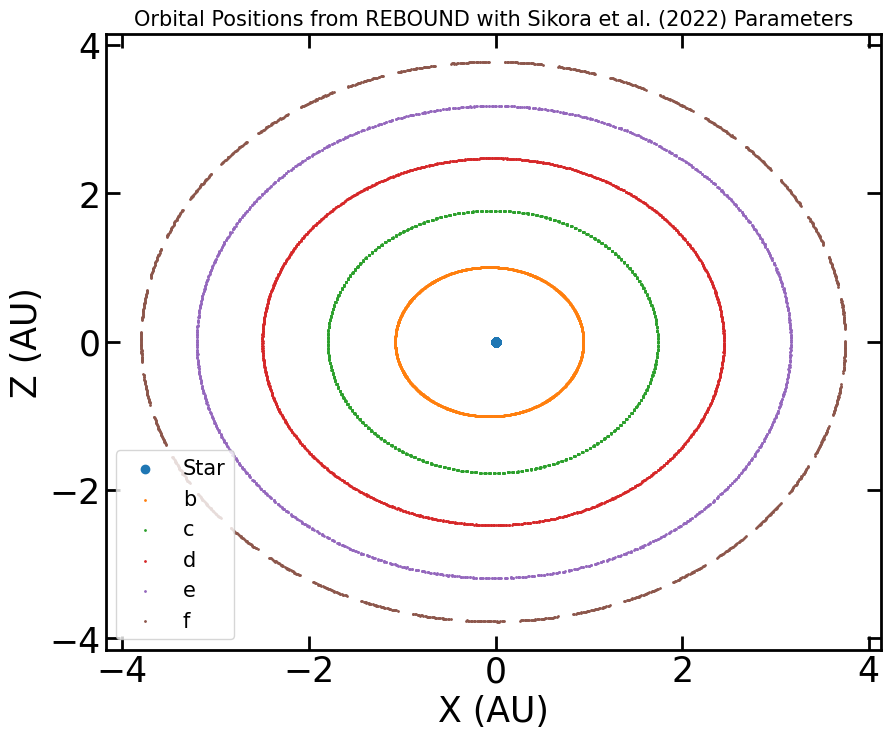

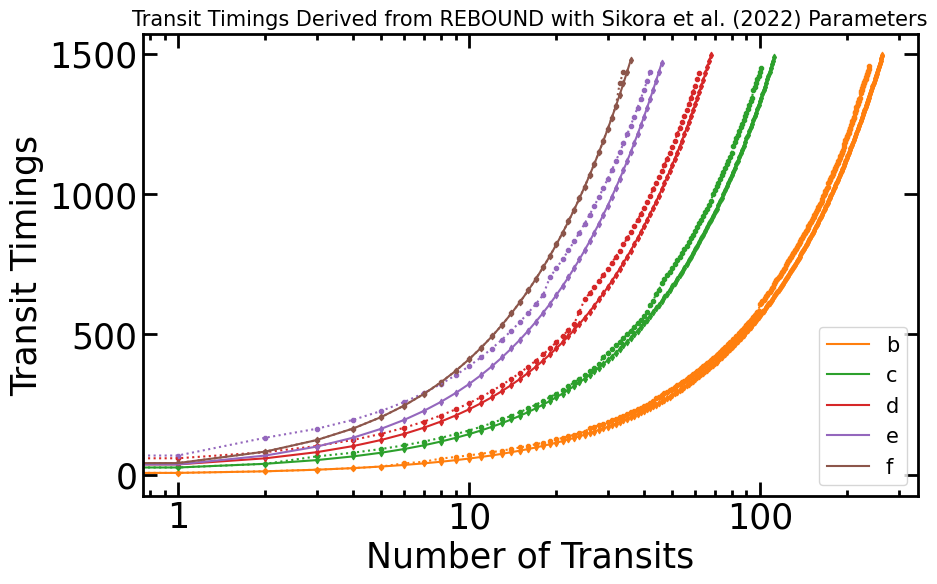

In [13]:
# Solving the nbody problem with REBOUND
posDict, simTimes = solve_nBody(System)
starOrb, planOrb = get_orbits(posDict)

_, fig, ax = setup_plot((10,8), logscale=0)
ax.scatter(starOrb.x[::100], starOrb.z[::100], label='Star')
for i, pOrb in enumerate(planOrb):
    ax.scatter(pOrb.x[::100], pOrb.z[::100], s=1, label=System['Names'][i])

ax.set_xlabel('X (AU)')
ax.set_ylabel('Z (AU)')
ax.set_title('Orbital Positions from REBOUND with Sikora et al. (2022) Parameters', fontsize=15)
ax.legend(fontsize=15)
plt.show()

# getting our transit timings!
transTimes = []
_, fig, ax = setup_plot((10,6), logscale=2)

for i, pOrb in enumerate(planOrb):
    tPlanet = getTransits(pOrb.x, pOrb.z, simTimes)
    transTimes.append(np.array(tPlanet))   
    
    simRange = np.arange(0, len(tPlanet))
    obsRange = np.arange(0, len(t0Corr[i]))
    
    ax.scatter(simRange, tPlanet, marker='d', color=System['colours'][i], s=10)
    ax.scatter(obsRange, t0Corr[i], marker='8', color=System['colours'][i], s=10)
    ax.plot(simRange, tPlanet, color=System['colours'][i], label=System['Names'][i])
    ax.plot(obsRange, t0Corr[i], ls=':', color=System['colours'][i])

ax.set_xlabel('Number of Transits')
ax.set_ylabel('Transit Timings')
ax.set_title('Transit Timings Derived from REBOUND with Sikora et al. (2022) Parameters', fontsize=15)
ax.legend(fontsize=15)
ax.legend(loc='lower right', fontsize=15)
plt.show()

# Monte Carlo Markov Chain

### 1. Setting Priors to limit the parameter search

This will limit the search for the good fit parameters and make sure the simulator does not input an invalid value (ex: ecc of -1). We apply this to all the parameters that we wish to fit and denote the sigma which determines our stepsize. 

In [25]:
# If not our estimates, then taken from Sikora et al. (2022).

# Kepler determines the period very very accurately so our bounds are the periods are quite strict.
pUpperSig = np.array([0.00005, 0.00005, 0.00006, 0.0002, 0.0002])
pLowerSig = np.array([0.00005, 0.00005, 0.00004, 0.0002, 0.0002])
pInfo = {'upperPrior': P + 3*pUpperSig,
    'lowerPrior': P - 3*pLowerSig,
    'sig': pUpperSig}

# These are the upper bounds for the eccentricity, so they become our priors.
eccBound = np.array([0.2, 0.05, 0.03, 0.02, 0.02])
eccInfo = {'upperPrior': eccBound,
    'lowerPrior': np.zeros((5,)),
    'sig': eccBound*0.08}

# These are our upper and lower bounds for our masses, and we use them as our priors, in Earth masses. 
mUpperPrior = np.array([50, 19, 8.2, 6.6 + 3*1.1, 8.2 + 3*1.6])
mLowerPrior = np.array([0.01, 0.01, 0.01, 6.6 - 3*1.0, 8.2 - 3*1.2]) 
mpInfo = {'upperPrior': mUpperPrior * (ast.M_earth/ast.M_sun).value,
    'lowerPrior': mLowerPrior * (ast.M_earth/ast.M_sun).value,
    'sig': np.append(mUpperPrior[:3]*0.15, [1.1, 1.6]) * (ast.M_earth/ast.M_sun).value}

fTInfo = {'upperPrior': np.repeat(2*np.pi, 5),
          'lowerPrior': np.zeros((5,)),
          'sig': np.repeat(8*(np.pi/180), 5)} # let there be a sigma of 8 degrees. 

global priors
priors = {
    'Period': pInfo,
    'Mass': mpInfo,
    'Ecc': eccInfo,
    'f_true': fTInfo}

### 2. Our MCMC Functions to Calculate the Likelihood
In our function prob, we determine the probability that we will take a step. First, we consider our priors - if our parameters are beyond bounds, we can immediately discard our step. If not, we evaluate our model and compare our chi-squared value in order to determine this probability/likelihood.

In [26]:
def chi_fun(y, planetMod):
    '''
    To calculate our chi-Squared value. We negate the errors as they tend to blow up our chi-Squared value.
    '''
    return np.sum(((y - planetMod))**2/y)
    
def like(theta, data, old_chi):
    '''
    We organise our parameters and then plug them into our nBody simulation to get our simulated transits.
    We have to account for a difference in length between the original data and the simulated data. 
    '''
    sysTrans = systemTransits(theta) # theta are our orbital parameters
    obsTrans, obsTransErr = data[0], data[1] # Because it is originally a tuple of (data, errors)
    nModel = len(sysTrans)
    chiSqPlan = np.zeros((nModel,))
    
    for i in range(nModel):
        
        pObsT0 = obsTrans[i]
        # First point of action is to match the lengths and remove the 'extra values'.
        # print(f'For the simulated, we have length {len(sysTrans[i])}, and for the observed, we have {len(pObsT0)}.')
        pSimT0 = matchTime(sysTrans[i], System['ZeroIndices'][i], len(pObsT0))
        # print(f'The original length was {len(sysTrans[i])}, our matched times are {len(pSimT0)}.')

        if len(pObsT0) > len(pSimT0): # Because matchTime will account for the other case.
            pObsT0 = pObsT0[:len(pSimT0)]
            obsTransErr[i] =  obsTransErr[i][:len(pSimT0)]
                    
        # Calculating our chi-squared value for the planet: will we keep this step or will we not?
        chiSqPlan[i] = chi_fun(pObsT0, pSimT0)
    
    chiSq = np.sum(chiSqPlan)
    # as used in class: np.exp(0.5*(chisq[i-1]-chi_new))
    like = np.exp(-0.5*(chiSq-old_chi)) 

    file = open('chi_param_chain.txt', 'a') # Updating txt file
    file.write(str(chiSq)+'\t'+str(theta)+'\n')
    file.close()
    
    return like, chiSq, chiSqPlan

# Setting up boundary conditions
def prior(theta):
    '''
    theta should be in the form: theta = [System['Period'], System['Mass'], System['Ecc'], System['f_true']]
    
    Our priors decide whether or not our proposed values are valid. Our eccentricity values are less than our
    initial values, therefore, our prior must always be less than these values. 
    '''
    parCons = []
    
    for i, parTuple in enumerate(priors.items()):
        # We have a tuple of (key, item) so we take the item entry. 
        parDict = parTuple[1]
        # Are all the values for the parameter within the upper and lower bounds?
        belowUpper = theta[i] <= parDict['upperPrior']
        aboveLower = theta[i] >= parDict['lowerPrior']
        # Save the condition for the parameter and append it to all the conditions
        parCon = np.all(np.logical_and(belowUpper, aboveLower))
        parCons.append(parCon)
        
    if np.all(parCons): # if all the conditions are satisfied, then we can continue.
        return 0.0
    # If we don't fufill these conditions, then we return infinity
    return np.inf 

# the parameters that we are fitting: period, mass, eccentricity and f_true.
def prob(theta, y, old_chi):
    '''
    This calculates the probability of whether or not we take the step. This is done in several steps.
    We unpack and reshape our parameters and then test where or not they pass the priors. If they do not,
    then, the value is automatically discarded.If they do, then we compare the difference in chiSq.
    
    theta should be in the form of theta = system b, c, d, e, f
    for the parameters of Period, Mass, Ecc, f_true and in that order!!!
    '''
    lp = prior(np.transpose(theta)) # Checking if the priors have been satisfied. 
    
    # To match the output length
    if not np.isfinite(lp):
        return -np.inf, None 
    
    likeliness, chi, _ = like(theta, y, old_chi)
    # because lp is 0.0 if it is not infinity, we use uniform priors.
    return likeliness, chi 

### 2. Determining our Step-Size/ New Parameters
Our trial steps are taken from a trial distribution, which are typically Gaussian. Unfortunately, due to our coarse simulation, using the errors will cause our step-size to run too small.Therefore, we use the sigma given in the cell above to constrain our selection.

In [27]:
# gaussFunc = lambda x, sig: np.exp(-1/2 * ((x)/sig)**2)

def getNewPar(theta, bigStep=False):
    '''
    To get our new values for our parameters: we draw from a Gaussian distribution centred at
    our parameter value and scaled by sigma.
    
    bigStep: we want to take a massive step, however, we do not want to do this for our period values.
    for the condition on f_true, because one of our planets begins at 2*np.pi, we want to ensure that
    it can explore the parameter space without the prior's restriction. 
    '''
    newPars = np.zeros(theta.shape)
    
    for i, parTuple in enumerate(priors.items()):
        # Unpacking the tuple for more readability
        parName, parDict = parTuple[0], parTuple[1]
        newPar = np.random.normal(loc=theta[:, i], scale=parDict['sig'])
        
        if bigStep and parName != 'Period':
            newPar = np.random.normal(loc=theta[:, i], scale=(parDict['sig']*3))
        if parName == 'f_true' and np.any(newPar > 2*np.pi):
            newPar[newPar > 2*np.pi] -= 2*np.pi
            
        newPars[:, i] = newPar
        
    return newPars

def assessStep(theta):
    '''
    We want to take a massive step but need to be careful that it isn't outside of our priors.
    Moreover, we avoid doing this to the period as it is relatively well determined.
    '''
    lp = np.inf
    newPars = np.zeros(theta.shape)
    
    while not np.isfinite(lp):
        
        newPars = getNewPar(theta, bigStep=True)
        lp = prior(np.transpose(newPars))
    
    return newPars

In [28]:
def run_mcmc(pars, data, checkThres=500):
    '''
    pars: the planet parameters that are our first guess.
    theta = np.transpose([System['Period'], System['Mass'], System['Ecc'], System['f_true']])
    
    data: the observed transit timings.
    nSamp: the length of the chain that we wish to run. 
    checkThres: the number of iterations we run before checking if our chiSq improvement.
    
    The algorithm to run our MCMC for!
    '''
    
    # Initialising the system - we only intend to find the chiSq value for our first guess.
    chain, chivec = [], []
    _, chisq, _ = like(pars, data, 0)
    
    count = 0
    
    while (count<100): # We want at least 100 * checkThres values of a decent chain. 
        
        # Using tqdm to be able to measure how long we've been running for 
        for i in tqdm(range(checkThres)): # Run the checkThres values. 
            
            pNew = getNewPar(pars)
            like_ratio, chi_new = prob(pNew, data, chisq)
            # if the ratio is greater than the random, then we will take it. 
            if like_ratio > np.random.rand():
                pars, chisq = pNew, chi_new
            # Append our values, either pNew is discarded or it is reassigned and appended
            chain.append(pars)
            chivec.append(chisq)
            
        
        if (np.abs(chivec[-1] - chivec[-checkThres]) < 10**(-4)) and \
        (np.abs(chivec[-1] - chivec[-checkThres//2]) < 10**(-4)):
            
            # We reset the count.
            count = 0
            
            print(f'The chiSq we are stuck at {chivec[-1]}.')
        
            for i in tqdm(range(checkThres)): # Run the checkThres values. 
                pars = assessStep(pars)
                like_ratio, chi_new = prob(pNew, data, chisq)
                # if the ratio is greater than the random, then we will take it. 
                if like_ratio > np.random.rand():
                    pars, chisq = pNew, chi_new
                # Append our values, either pNew is discarded or it is reassigned and appended
                chain.append(pars)
                chivec.append(chisq)
                
            print(f'The chiSq we have ended up at is {chivec[-1]}.')
            
        count += 1
           
    return chain,chivec

In [29]:
# Resetting file, so each time we write, it is better. 
reset = open("chi_param_chain.txt",'w')
reset.close()

# Adding title
file =  open('chi_param_chain.txt', 'a')
file.write('chi\tparam\n')
file.close()

# Defining our initial theta for our MCMC algorithm
sikoraSys = np.transpose([System['Period'], System['Mass'], System['Ecc'], System['f_true']])
theta = assessStep(sikoraSys)

In [ ]:
chain, chivec = run_mcmc(theta, data)

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  0%|                                           | 1/500 [00:06<54:21,  6.54s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▎                                          | 4/500 [00:13<25:21,  3.07s/it]

264
113
69
48
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  2%|▉                                         | 11/500 [00:19<12:17,  1.51s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█▎                                        | 15/500 [00:26<12:40,  1.57s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|█▉                                        | 23/500 [00:33<09:29,  1.19s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██                                        | 24/500 [00:40<13:19,  1.68s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██▎                                       | 27/500 [00:47<14:44,  1.87s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▌                                       | 30/500 [00:54<15:40,  2.00s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|██▊                                       | 34/500 [01:01<14:50,  1.91s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|███                                       | 36/500 [01:08<17:14,  2.23s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▋                                      | 44/500 [01:15<11:27,  1.51s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████                                      | 48/500 [01:22<11:44,  1.56s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▌                                     | 54/500 [01:29<10:28,  1.41s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▌                                    | 66/500 [01:35<07:04,  1.02it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|███████▉                                  | 94/500 [01:42<03:30,  1.93it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|████████                                  | 96/500 [01:49<04:39,  1.44it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 22%|█████████                                | 110/500 [01:56<03:59,  1.63it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▎                              | 125/500 [02:03<03:29,  1.79it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▊                              | 132/500 [02:10<03:55,  1.56it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▋                            | 155/500 [02:17<02:43,  2.11it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████                          | 184/500 [02:24<01:55,  2.73it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 37%|███████████████▏                         | 185/500 [02:30<02:40,  1.96it/s]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████                       | 220/500 [02:37<01:36,  2.90it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|██████████████████▏                      | 222/500 [02:44<02:11,  2.11it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▎                 | 285/500 [02:51<00:50,  4.22it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▊                 | 290/500 [02:58<01:06,  3.17it/s]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▊                 | 291/500 [03:05<01:33,  2.24it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|███████████████████████████▏             | 331/500 [03:12<00:51,  3.26it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 68%|███████████████████████████▉             | 341/500 [03:19<00:58,  2.72it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████            | 355/500 [03:26<00:57,  2.50it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 363/500 [03:33<01:05,  2.09it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▌          | 372/500 [03:40<01:09,  1.85it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▊          | 376/500 [03:47<01:24,  1.47it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|██████████████████████████████▉          | 378/500 [03:54<01:50,  1.11it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 387/500 [04:01<01:37,  1.16it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▋        | 399/500 [04:08<01:15,  1.34it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 402/500 [04:15<01:32,  1.06it/s]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▎    | 443/500 [04:22<00:22,  2.53it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▌    | 446/500 [04:29<00:28,  1.90it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|██████████████████████████████████████▏  | 465/500 [04:36<00:16,  2.16it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 95%|███████████████████████████████████████  | 476/500 [04:43<00:12,  1.99it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [04:50<00:00,  1.72it/s]


265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██▎                                       | 27/500 [00:06<02:00,  3.94it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|██▊                                       | 33/500 [00:13<03:38,  2.14it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 12%|█████                                     | 60/500 [00:20<02:28,  2.96it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▎                                    | 63/500 [00:27<03:41,  1.97it/s]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▍                                    | 64/500 [00:34<05:34,  1.30it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▉                                   | 82/500 [00:41<03:58,  1.75it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▏                                | 100/500 [00:48<03:16,  2.03it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▋                               | 118/500 [00:55<02:52,  2.21it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▊                               | 119/500 [01:01<04:03,  1.56it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|██████████                               | 122/500 [01:08<05:09,  1.22it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████                              | 135/500 [01:15<04:18,  1.41it/s]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [01:22<05:37,  1.07it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▍                            | 151/500 [01:29<04:17,  1.36it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▍                            | 152/500 [01:36<05:51,  1.01s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▊                          | 180/500 [01:43<02:49,  1.89it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 38%|███████████████▍                         | 188/500 [01:50<03:07,  1.66it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▎                       | 211/500 [01:57<02:13,  2.16it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▊                       | 217/500 [02:04<02:39,  1.78it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|█████████████████▉                       | 218/500 [02:11<03:39,  1.29it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████▏                      | 222/500 [02:18<04:17,  1.08it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▌                      | 226/500 [02:25<04:56,  1.08s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▌                      | 227/500 [02:32<06:33,  1.44s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 47%|███████████████████▎                     | 235/500 [02:39<05:17,  1.20s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▊                     | 241/500 [02:46<05:07,  1.19s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 49%|███████████████████▉                     | 243/500 [02:53<06:22,  1.49s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▌                | 299/500 [03:00<01:09,  2.90it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▌               | 311/500 [03:07<01:14,  2.53it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▋              | 326/500 [03:13<01:11,  2.43it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▍            | 347/500 [03:21<01:00,  2.55it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▊            | 351/500 [03:28<01:15,  1.97it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|█████████████████████████████            | 355/500 [03:35<01:33,  1.56it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|█████████████████████████████▎           | 357/500 [03:42<02:01,  1.18it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 363/500 [03:49<02:06,  1.08it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|████████████████████████████████▏        | 392/500 [03:56<00:53,  2.01it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 402/500 [04:02<00:53,  1.84it/s]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▊       | 412/500 [04:09<00:50,  1.73it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|███████████████████████████████████▉     | 439/500 [04:16<00:25,  2.38it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▌    | 446/500 [04:23<00:27,  1.97it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 91%|█████████████████████████████████████▏   | 454/500 [04:30<00:26,  1.70it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 460/500 [04:38<00:27,  1.44it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████▏  | 466/500 [04:44<00:26,  1.27it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 479/500 [04:51<00:14,  1.45it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 97%|███████████████████████████████████████▉ | 487/500 [04:58<00:09,  1.36it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▍| 493/500 [05:05<00:05,  1.22it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [05:12<00:00,  1.60it/s]


265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  0%|▏                                          | 2/500 [00:06<28:08,  3.39s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▍                                          | 5/500 [00:13<20:44,  2.51s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|██▊                                       | 33/500 [00:18<03:13,  2.41it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▋                                      | 44/500 [00:23<03:21,  2.27it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▌                                     | 55/500 [00:29<03:23,  2.18it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▋                                     | 56/500 [00:35<05:01,  1.47it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 12%|█████                                     | 61/500 [00:41<05:54,  1.24it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▌                                    | 66/500 [00:47<06:31,  1.11it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▋                                    | 67/500 [00:53<09:02,  1.25s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▏                                   | 73/500 [00:59<08:13,  1.16s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 74/500 [01:06<11:17,  1.59s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████                                   | 84/500 [01:12<07:29,  1.08s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|███████▉                                  | 95/500 [01:18<05:41,  1.19it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▎                                | 102/500 [01:25<05:49,  1.14it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 21%|████████▍                                | 103/500 [01:31<07:49,  1.18s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▌                                | 105/500 [01:37<09:22,  1.42s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▌                               | 117/500 [01:43<05:55,  1.08it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▋                               | 118/500 [01:49<07:49,  1.23s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▎                              | 126/500 [01:55<06:35,  1.06s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [02:01<04:59,  1.21it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▋                             | 142/500 [02:08<05:32,  1.08it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▊                             | 144/500 [02:14<06:59,  1.18s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▉                             | 145/500 [02:20<09:14,  1.56s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▉                             | 146/500 [02:27<11:54,  2.02s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▋                            | 154/500 [02:32<07:44,  1.34s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▋                            | 155/500 [02:39<10:09,  1.77s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [02:45<07:44,  1.37s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|█████████████▊                           | 168/500 [02:52<07:00,  1.27s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|█████████████▉                           | 170/500 [02:58<08:25,  1.53s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|██████████████                           | 172/500 [03:04<09:47,  1.79s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▏                          | 173/500 [03:10<12:16,  2.25s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▊                          | 181/500 [03:16<07:30,  1.41s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▍                        | 200/500 [03:22<03:33,  1.41it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▎                      | 223/500 [03:29<02:12,  2.08it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 49%|████████████████████                     | 244/500 [03:35<01:44,  2.44it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 50%|████████████████████▌                    | 250/500 [03:41<02:01,  2.05it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|████████████████████▉                    | 255/500 [03:47<02:25,  1.68it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▋                   | 265/500 [03:53<02:20,  1.67it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████                   | 269/500 [03:59<02:46,  1.39it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 59%|████████████████████████▏                | 295/500 [04:04<01:27,  2.33it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|█████████████████████████▏               | 307/500 [04:10<01:23,  2.31it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▍              | 322/500 [04:15<01:14,  2.40it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▏            | 344/500 [04:21<00:54,  2.87it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▊            | 351/500 [04:26<01:02,  2.40it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████            | 355/500 [04:31<01:15,  1.93it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|█████████████████████████████▎           | 357/500 [04:37<01:37,  1.47it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▉          | 377/500 [04:42<00:57,  2.14it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▍         | 383/500 [04:48<01:03,  1.83it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 386/500 [04:53<01:17,  1.47it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 79%|████████████████████████████████▎        | 394/500 [04:59<01:13,  1.45it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 396/500 [05:04<01:34,  1.10it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▋        | 399/500 [05:10<01:47,  1.06s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▌       | 409/500 [05:16<01:16,  1.18it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▉      | 426/500 [05:22<00:43,  1.68it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 436/500 [05:27<00:37,  1.72it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 445/500 [05:33<00:32,  1.69it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████▎  | 467/500 [05:38<00:13,  2.37it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 95%|███████████████████████████████████████  | 477/500 [05:44<00:10,  2.22it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 480/500 [05:49<00:11,  1.71it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▊ | 485/500 [05:55<00:10,  1.48it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 98%|████████████████████████████████████████ | 489/500 [06:00<00:08,  1.26it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 495/500 [06:06<00:04,  1.21it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [06:11<00:00,  1.35it/s]


265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▋                                          | 8/500 [00:05<05:33,  1.47it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█▎                                        | 16/500 [00:10<05:30,  1.47it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▋                                        | 20/500 [00:16<07:02,  1.14it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▎                                       | 28/500 [00:21<06:13,  1.26it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▌                                       | 31/500 [00:27<07:42,  1.01it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▋                                       | 32/500 [00:32<10:33,  1.35s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|███                                       | 37/500 [00:38<09:53,  1.28s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▎                                      | 39/500 [00:43<11:55,  1.55s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▌                                      | 43/500 [00:49<11:27,  1.50s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▌                                     | 54/500 [00:54<06:45,  1.10it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▋                                     | 56/500 [01:00<08:32,  1.15s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▊                                     | 57/500 [01:05<11:12,  1.52s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▋                                    | 67/500 [01:10<06:59,  1.03it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 14%|██████                                    | 72/500 [01:15<07:00,  1.02it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▍                                   | 77/500 [01:21<07:03,  1.00s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▌                                   | 78/500 [01:26<09:30,  1.35s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▉                                   | 82/500 [01:32<09:26,  1.35s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▏                                  | 86/500 [01:37<09:19,  1.35s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▎                                  | 87/500 [01:42<11:51,  1.72s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 18%|███████▍                                  | 88/500 [01:47<14:47,  2.15s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 18%|███████▌                                  | 90/500 [01:53<15:26,  2.26s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|████████▏                                 | 97/500 [01:58<09:24,  1.40s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▏                                 | 98/500 [02:03<12:03,  1.80s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▎                                | 101/500 [02:08<11:51,  1.78s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▎                                | 102/500 [02:14<14:49,  2.23s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|████████▉                                | 109/500 [02:19<09:22,  1.44s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|█████████▏                               | 112/500 [02:25<09:54,  1.53s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▎                               | 113/500 [02:30<12:33,  1.95s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▎                               | 114/500 [02:35<15:26,  2.40s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▍                               | 115/500 [02:41<18:19,  2.86s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▌                               | 116/500 [02:46<21:49,  3.41s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▌                               | 117/500 [02:52<25:06,  3.93s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▋                               | 118/500 [02:58<27:58,  4.39s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▊                               | 119/500 [03:04<30:01,  4.73s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▊                               | 120/500 [03:10<31:45,  5.01s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|██████████                               | 122/500 [03:15<25:22,  4.03s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 25%|██████████▎                              | 126/500 [03:21<16:19,  2.62s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▌                              | 129/500 [03:27<14:40,  2.37s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▋                              | 131/500 [03:32<15:11,  2.47s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████                              | 135/500 [03:38<12:04,  1.99s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [03:43<13:01,  2.15s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 28%|███████████▋                             | 142/500 [03:49<10:03,  1.69s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▋                             | 143/500 [03:54<12:31,  2.11s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▊                             | 144/500 [04:00<15:14,  2.57s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▉                             | 145/500 [04:05<17:53,  3.02s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▏                            | 148/500 [04:10<14:37,  2.49s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▏                            | 149/500 [04:15<17:22,  2.97s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▌                            | 153/500 [04:21<12:30,  2.16s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|████████████▉                            | 158/500 [04:27<09:46,  1.72s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████                            | 159/500 [04:33<12:30,  2.20s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [04:38<11:55,  2.12s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 33%|█████████████▎                           | 163/500 [04:44<14:23,  2.56s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 33%|█████████████▋                           | 167/500 [04:50<11:29,  2.07s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|██████████████                           | 171/500 [04:55<09:56,  1.81s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 34%|██████████████                           | 172/500 [05:01<12:19,  2.25s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▏                          | 173/500 [05:06<14:49,  2.72s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▍                          | 176/500 [05:12<13:08,  2.43s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▌                          | 177/500 [05:18<15:54,  2.96s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▊                          | 181/500 [05:24<11:58,  2.25s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 36%|██████████████▉                          | 182/500 [05:29<14:21,  2.71s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████                          | 183/500 [05:35<16:51,  3.19s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 37%|███████████████▎                         | 186/500 [05:40<13:37,  2.60s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▍                         | 188/500 [05:45<13:40,  2.63s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▍                         | 189/500 [05:51<16:01,  3.09s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▋                         | 191/500 [05:56<15:21,  2.98s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 38%|███████████████▋                         | 192/500 [06:02<17:53,  3.48s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|███████████████▊                         | 193/500 [06:08<20:17,  3.97s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 39%|████████████████                         | 196/500 [06:13<15:10,  3.00s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▏                        | 198/500 [06:19<14:55,  2.96s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▍                        | 200/500 [06:25<14:35,  2.92s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 41%|████████████████▋                        | 203/500 [06:30<12:24,  2.51s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 41%|████████████████▊                        | 205/500 [06:36<12:37,  2.57s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 41%|████████████████▉                        | 207/500 [06:42<12:54,  2.64s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▏                       | 210/500 [06:47<11:10,  2.31s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▍                       | 212/500 [06:52<11:31,  2.40s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|█████████████████▉                       | 219/500 [06:58<06:53,  1.47s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|██████████████████                       | 221/500 [07:03<08:01,  1.73s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|██████████████████▏                      | 222/500 [07:09<10:08,  2.19s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▎                      | 223/500 [07:15<12:27,  2.70s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▎                      | 224/500 [07:20<14:42,  3.20s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▍                      | 225/500 [07:26<16:55,  3.69s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 46%|██████████████████▊                      | 229/500 [07:32<11:18,  2.50s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 46%|███████████████████                      | 232/500 [07:37<10:03,  2.25s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████                      | 233/500 [07:43<12:15,  2.76s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████▏                     | 234/500 [07:48<14:24,  3.25s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▊                     | 241/500 [07:54<07:18,  1.69s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|████████████████████▉                    | 255/500 [07:59<03:27,  1.18it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 258/500 [08:04<03:59,  1.01it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▎                   | 260/500 [08:10<04:53,  1.22s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|█████████████████████▉                   | 268/500 [08:15<03:44,  1.03it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████▏                  | 270/500 [08:20<04:32,  1.19s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▏                  | 271/500 [08:25<05:54,  1.55s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▋                  | 277/500 [08:31<04:44,  1.28s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████▏                | 295/500 [08:36<02:11,  1.56it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 59%|████████████████████████▎                | 297/500 [08:42<02:51,  1.19it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|█████████████████████████                | 305/500 [08:48<02:36,  1.25it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|█████████████████████████                | 306/500 [08:53<03:27,  1.07s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▍               | 310/500 [08:58<03:34,  1.13s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▌               | 312/500 [09:04<04:16,  1.36s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▋               | 313/500 [09:09<05:28,  1.76s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▋              | 325/500 [09:14<02:42,  1.08it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▋              | 326/500 [09:19<03:33,  1.23s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|██████████████████████████▉              | 329/500 [09:25<03:52,  1.36s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|███████████████████████████▏             | 331/500 [09:30<04:30,  1.60s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▋             | 338/500 [09:36<03:17,  1.22s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▎           | 358/500 [09:41<01:25,  1.67it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▌           | 361/500 [09:47<01:43,  1.34it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▋           | 362/500 [09:52<02:18,  1.01s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|██████████████████████████████           | 366/500 [09:57<02:25,  1.09s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▌          | 372/500 [10:03<02:12,  1.03s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 386/500 [10:08<01:18,  1.45it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 395/500 [10:14<01:08,  1.53it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▊        | 400/500 [10:19<01:13,  1.36it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 83%|██████████████████████████████████       | 415/500 [10:24<00:47,  1.80it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▏     | 429/500 [10:30<00:35,  2.01it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 437/500 [10:35<00:34,  1.85it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▊    | 449/500 [10:41<00:25,  1.97it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 451/500 [10:46<00:32,  1.50it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 91%|█████████████████████████████████████▏   | 454/500 [10:52<00:38,  1.19it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 91%|█████████████████████████████████████▍   | 457/500 [10:57<00:42,  1.01it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 95%|███████████████████████████████████████  | 476/500 [11:02<00:13,  1.77it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▌ | 482/500 [11:08<00:11,  1.58it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▌ | 483/500 [11:13<00:14,  1.14it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▊| 497/500 [11:19<00:01,  1.55it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [11:24<00:00,  1.37s/it]


265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  1%|▎                                          | 4/500 [00:05<11:27,  1.39s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█▎                                        | 15/500 [00:10<05:26,  1.49it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▋                                        | 20/500 [00:16<06:30,  1.23it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██▏                                       | 26/500 [00:21<06:45,  1.17it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▋                                       | 32/500 [00:27<06:47,  1.15it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|██▊                                       | 33/500 [00:33<09:41,  1.25s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|██▉                                       | 35/500 [00:38<11:44,  1.51s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|███                                       | 36/500 [00:44<15:07,  1.96s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|███                                       | 37/500 [00:49<18:43,  2.43s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▏                                      | 38/500 [00:54<22:31,  2.93s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▎                                      | 39/500 [01:00<26:04,  3.39s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▋                                      | 44/500 [01:05<15:41,  2.06s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████▎                                     | 52/500 [01:10<09:22,  1.26s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▌                                     | 54/500 [01:16<11:10,  1.50s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 14%|█████▊                                    | 69/500 [01:21<05:26,  1.32it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|█████▉                                    | 71/500 [01:26<06:57,  1.03it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 21%|████████▌                                | 105/500 [01:32<02:28,  2.66it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|████████▉                                | 109/500 [01:37<03:05,  2.11it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▊                               | 120/500 [01:42<02:58,  2.12it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▉                               | 121/500 [01:47<04:04,  1.55it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▍                              | 128/500 [01:52<04:09,  1.49it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▌                              | 129/500 [01:57<05:38,  1.10it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▋                              | 131/500 [02:03<07:01,  1.14s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▊                              | 132/500 [02:08<09:06,  1.48s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [02:13<07:56,  1.31s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 28%|███████████▌                             | 141/500 [02:18<07:51,  1.31s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▊                             | 144/500 [02:23<08:22,  1.41s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▏                            | 148/500 [02:29<08:05,  1.38s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▎                            | 150/500 [02:34<09:19,  1.60s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [02:39<05:05,  1.11it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▌                          | 178/500 [02:45<03:12,  1.68it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▉                          | 182/500 [02:50<03:46,  1.41it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████                          | 183/500 [02:55<05:03,  1.04it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|████████████████▏                        | 197/500 [03:00<03:18,  1.52it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▍                        | 201/500 [03:06<03:50,  1.30it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▋                        | 204/500 [03:11<04:37,  1.07it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▋                       | 216/500 [03:17<03:22,  1.40it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████                       | 221/500 [03:22<03:40,  1.26it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▍                      | 225/500 [03:27<04:07,  1.11it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|██████████████████▉                      | 231/500 [03:33<03:59,  1.12it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████▍                     | 237/500 [03:40<04:21,  1.00it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 48%|███████████████████▌                     | 238/500 [03:45<05:34,  1.28s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▊                     | 242/500 [03:51<05:32,  1.29s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 49%|████████████████████▎                    | 247/500 [03:56<05:06,  1.21s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▋                    | 252/500 [04:01<04:46,  1.15s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|████████████████████▉                    | 256/500 [04:06<04:51,  1.20s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 52%|█████████████████████▏                   | 258/500 [04:12<06:01,  1.50s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 259/500 [04:18<07:33,  1.88s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▌                   | 263/500 [04:23<06:44,  1.71s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▊                   | 266/500 [04:28<06:42,  1.72s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▏                  | 271/500 [04:34<05:31,  1.45s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████▎                  | 272/500 [04:39<07:08,  1.88s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▍                  | 273/500 [04:45<08:52,  2.35s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▋                  | 276/500 [04:50<08:06,  2.17s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 56%|███████████████████████                  | 281/500 [04:56<06:02,  1.65s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 56%|███████████████████████                  | 282/500 [05:01<07:38,  2.10s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▎                 | 284/500 [05:07<08:10,  2.27s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▊                 | 290/500 [05:12<05:33,  1.59s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▌                | 299/500 [05:18<03:38,  1.09s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▌                | 300/500 [05:24<04:49,  1.45s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|████████████████████████▊                | 303/500 [05:29<05:05,  1.55s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|█████████████████████████                | 306/500 [05:35<05:19,  1.65s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▌               | 312/500 [05:40<04:06,  1.31s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▋               | 313/500 [05:46<05:22,  1.72s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████               | 318/500 [05:52<04:30,  1.49s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▏              | 319/500 [05:57<05:45,  1.91s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▍              | 323/500 [06:03<04:58,  1.68s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▌              | 324/500 [06:08<06:10,  2.11s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|██████████████████████████▉              | 328/500 [06:13<05:06,  1.78s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▍             | 334/500 [06:20<04:12,  1.52s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▍             | 335/500 [06:26<05:19,  1.94s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▌             | 336/500 [06:32<06:33,  2.40s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▎            | 345/500 [06:38<03:26,  1.33s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▍            | 347/500 [06:43<04:01,  1.58s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▊            | 352/500 [06:49<03:28,  1.41s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|████████████████████████████▉            | 353/500 [06:55<04:25,  1.80s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|█████████████████████████████            | 354/500 [07:00<05:29,  2.25s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████▏           | 356/500 [07:06<05:44,  2.39s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████▎           | 357/500 [07:11<06:46,  2.84s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|██████████████████████████████           | 366/500 [07:17<03:03,  1.37s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▏          | 368/500 [07:22<03:34,  1.63s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 369/500 [07:28<04:31,  2.08s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 370/500 [07:34<05:33,  2.57s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 76%|███████████████████████████████          | 379/500 [07:42<02:59,  1.48s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|███████████████████████████████▏         | 381/500 [07:47<03:22,  1.71s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 386/500 [07:53<02:49,  1.49s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 387/500 [07:58<03:28,  1.85s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|███████████████████████████████▉         | 389/500 [08:03<03:43,  2.02s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|████████████████████████████████▏        | 392/500 [08:08<03:27,  1.92s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▎        | 394/500 [08:16<04:04,  2.31s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 395/500 [08:24<05:26,  3.11s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 401/500 [08:29<03:11,  1.93s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 406/500 [08:36<02:39,  1.69s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▌       | 409/500 [08:42<02:39,  1.76s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 84%|██████████████████████████████████▎      | 419/500 [08:47<01:28,  1.10s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▍      | 420/500 [08:53<01:53,  1.42s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▏     | 429/500 [08:59<01:13,  1.04s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 436/500 [09:04<01:01,  1.04it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 88%|███████████████████████████████████▉     | 439/500 [09:10<01:07,  1.10s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|████████████████████████████████████▏    | 442/500 [09:15<01:11,  1.24s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 444/500 [09:20<01:21,  1.46s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 450/500 [09:26<01:02,  1.25s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|█████████████████████████████████████    | 452/500 [09:31<01:11,  1.50s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 91%|█████████████████████████████████████▏   | 454/500 [09:37<01:18,  1.71s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▎   | 455/500 [09:44<01:47,  2.38s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▍   | 456/500 [09:49<02:04,  2.82s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 459/500 [09:55<01:39,  2.42s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 460/500 [10:00<01:57,  2.93s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▉   | 462/500 [10:06<01:48,  2.84s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [10:11<00:00,  1.22s/it]


265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▉                                         | 11/500 [00:05<04:17,  1.90it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██                                        | 24/500 [00:11<03:40,  2.16it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████▎                                     | 51/500 [00:17<02:14,  3.35it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▌                                    | 66/500 [00:22<02:17,  3.15it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▌                                   | 78/500 [00:27<02:32,  2.77it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▌                                  | 90/500 [00:34<02:52,  2.37it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▉                               | 121/500 [00:40<01:51,  3.40it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 25%|██████████▍                              | 127/500 [00:45<02:19,  2.67it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▋                              | 130/500 [00:51<03:07,  1.97it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [00:57<03:31,  1.72it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▉                             | 146/500 [01:03<03:31,  1.67it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 38%|███████████████▍                         | 188/500 [01:09<01:31,  3.42it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▌                        | 202/500 [01:14<01:35,  3.11it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▊                        | 205/500 [01:20<02:07,  2.32it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████▏                      | 222/500 [01:26<01:50,  2.51it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 50%|████████████████████▌                    | 251/500 [01:32<01:16,  3.24it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 57%|███████████████████████▌                 | 287/500 [01:38<00:53,  4.00it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▌                | 300/500 [01:44<00:56,  3.52it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|████████████████████████▉                | 304/500 [01:49<01:11,  2.73it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 64%|██████████████████████████▎              | 321/500 [01:55<01:03,  2.83it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▊              | 327/500 [02:00<01:13,  2.34it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▏            | 344/500 [02:06<01:01,  2.56it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▋            | 350/500 [02:11<01:11,  2.10it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 363/500 [02:17<01:04,  2.12it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 369/500 [02:23<01:13,  1.78it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▋          | 374/500 [02:29<01:23,  1.51it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▉          | 377/500 [02:35<01:41,  1.21it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▍         | 384/500 [02:40<01:34,  1.23it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 396/500 [02:46<01:09,  1.49it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▊        | 400/500 [02:52<01:20,  1.24it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 421/500 [02:58<00:39,  1.98it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 86%|███████████████████████████████████▎     | 431/500 [03:03<00:35,  1.95it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 436/500 [03:08<00:38,  1.64it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 470/500 [03:14<00:09,  3.00it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 95%|███████████████████████████████████████  | 476/500 [03:19<00:09,  2.46it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 480/500 [03:25<00:10,  1.94it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▌ | 482/500 [03:30<00:12,  1.46it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 98%|████████████████████████████████████████ | 489/500 [03:36<00:08,  1.37it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 98%|████████████████████████████████████████▎| 492/500 [03:42<00:07,  1.11it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 494/500 [03:48<00:06,  1.14s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [03:53<00:00,  2.14it/s]


265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  1%|▎                                          | 4/500 [00:05<11:08,  1.35s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  1%|▍                                          | 5/500 [00:10<19:51,  2.41s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▍                                       | 29/500 [00:16<03:26,  2.28it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|███                                       | 36/500 [00:21<04:02,  1.91it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|███                                       | 37/500 [00:26<06:00,  1.28it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▏                                      | 38/500 [00:32<08:29,  1.10s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▋                                      | 44/500 [00:37<07:53,  1.04s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▉                                      | 47/500 [00:43<09:12,  1.22s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▎                                    | 63/500 [00:48<04:51,  1.50it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▏                                   | 74/500 [00:53<04:11,  1.70it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▍                                   | 76/500 [00:58<05:25,  1.30it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|███████▉                                  | 94/500 [01:03<03:28,  1.95it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 21%|████████▌                                | 104/500 [01:09<03:30,  1.88it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▋                                | 106/500 [01:15<04:37,  1.42it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▎                               | 113/500 [01:20<04:35,  1.41it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▍                               | 115/500 [01:25<05:48,  1.10it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▋                               | 118/500 [01:30<06:46,  1.06s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|██████████                               | 122/500 [01:36<07:03,  1.12s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 28%|███████████▍                             | 140/500 [01:41<03:38,  1.65it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▍                            | 152/500 [01:46<03:08,  1.85it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▋                            | 154/500 [01:51<04:07,  1.40it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▊                            | 156/500 [01:57<05:14,  1.09it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|████████████▉                            | 158/500 [02:02<06:30,  1.14s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|█████████████▊                           | 169/500 [02:08<04:33,  1.21it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▌                          | 178/500 [02:13<03:56,  1.36it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████▎                         | 186/500 [02:19<03:48,  1.38it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▎                        | 199/500 [02:24<03:02,  1.65it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▉                        | 206/500 [02:30<03:12,  1.53it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 41%|████████████████▉                        | 207/500 [02:36<04:21,  1.12it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▏                       | 210/500 [02:41<05:06,  1.06s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████▍                     | 237/500 [02:47<02:04,  2.11it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 48%|███████████████████▋                     | 240/500 [02:52<02:38,  1.64it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|█████████████████████                    | 257/500 [02:58<01:58,  2.05it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 258/500 [03:04<02:42,  1.49it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 259/500 [03:09<03:41,  1.09it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████                   | 269/500 [03:15<03:00,  1.28it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▋                  | 277/500 [03:20<02:45,  1.34it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|█████████████████████████▏               | 307/500 [03:26<01:13,  2.62it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 63%|█████████████████████████▊               | 315/500 [03:31<01:21,  2.26it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▉               | 317/500 [03:37<01:49,  1.67it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▍              | 322/500 [03:42<02:00,  1.47it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▊              | 327/500 [03:47<02:10,  1.32it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|██████████████████████████▉              | 329/500 [03:53<02:47,  1.02it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|███████████████████████████▏             | 331/500 [03:58<03:26,  1.22s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▎             | 333/500 [04:04<04:07,  1.48s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▍             | 335/500 [04:10<04:44,  1.72s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▋             | 338/500 [04:15<04:46,  1.77s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▊            | 351/500 [04:23<02:30,  1.01s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 364/500 [04:28<01:38,  1.37it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 369/500 [04:34<01:45,  1.24it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 370/500 [04:39<02:19,  1.08s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 422/500 [04:45<00:23,  3.39it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████      | 428/500 [04:51<00:26,  2.68it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▏     | 429/500 [04:56<00:35,  2.00it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 86%|███████████████████████████████████▎     | 431/500 [05:02<00:46,  1.50it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▍     | 432/500 [05:07<01:00,  1.12it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 437/500 [05:12<00:58,  1.08it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 88%|████████████████████████████████████▏    | 442/500 [05:17<00:55,  1.05it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▎    | 443/500 [05:23<01:13,  1.28s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 451/500 [05:28<00:49,  1.02s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▌   | 458/500 [05:33<00:38,  1.09it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▉   | 462/500 [05:38<00:38,  1.00s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|██████████████████████████████████████▏  | 466/500 [05:44<00:36,  1.08s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|██████████████████████████████████████▎  | 467/500 [05:49<00:47,  1.42s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 470/500 [05:54<00:45,  1.51s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 471/500 [06:00<00:55,  1.92s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 479/500 [06:05<00:26,  1.25s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▊ | 486/500 [06:11<00:14,  1.06s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▍| 493/500 [06:17<00:06,  1.03it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 495/500 [06:22<00:06,  1.21s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▋| 496/500 [06:28<00:06,  1.59s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [06:34<00:00,  1.27it/s]


265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  0%|                                           | 1/500 [00:05<47:03,  5.66s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  0%|▏                                          | 2/500 [00:11<46:22,  5.59s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▎                                          | 3/500 [00:16<44:44,  5.40s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  1%|▍                                          | 5/500 [00:21<31:26,  3.81s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  2%|▋                                          | 8/500 [00:27<23:07,  2.82s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  3%|█▏                                        | 14/500 [00:32<13:20,  1.65s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▋                                        | 20/500 [00:38<10:37,  1.33s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|█▉                                        | 23/500 [00:44<11:37,  1.46s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██▎                                       | 27/500 [00:49<11:10,  1.42s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▌                                       | 30/500 [00:54<11:47,  1.51s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|██▊                                       | 33/500 [01:00<12:28,  1.60s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▍                                      | 41/500 [01:06<08:50,  1.15s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▌                                      | 43/500 [01:11<10:44,  1.41s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▌                                     | 54/500 [01:17<06:45,  1.10it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▌                                     | 55/500 [01:22<09:03,  1.22s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|█████▉                                    | 70/500 [01:28<05:07,  1.40it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|█████████▏                               | 112/500 [01:33<01:58,  3.26it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▎                               | 114/500 [01:39<02:41,  2.39it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 25%|██████████                               | 123/500 [01:45<02:56,  2.14it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▊                              | 132/500 [01:51<03:09,  1.94it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|██████████▉                              | 133/500 [01:56<04:19,  1.41it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|██████████▉                              | 134/500 [02:02<05:50,  1.04it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [02:08<06:48,  1.13s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▉                             | 145/500 [02:13<05:39,  1.05it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▏                          | 173/500 [02:19<02:27,  2.22it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▎                          | 174/500 [02:24<03:18,  1.64it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▍                          | 176/500 [02:29<04:13,  1.28it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 36%|██████████████▌                          | 178/500 [02:35<05:19,  1.01it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 39%|███████████████▉                         | 194/500 [02:40<03:15,  1.56it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|███████████████▉                         | 195/500 [02:46<04:20,  1.17it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▍                        | 201/500 [02:53<04:48,  1.04it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▏                       | 209/500 [02:58<04:11,  1.16it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▍                       | 212/500 [03:04<04:48,  1.00s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▋                       | 216/500 [03:09<05:03,  1.07s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|██████████████████▏                      | 222/500 [03:14<04:43,  1.02s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|██████████████████▊                      | 229/500 [03:20<04:11,  1.08it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████                      | 233/500 [03:25<04:34,  1.03s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████▍                     | 237/500 [03:31<04:50,  1.10s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 49%|████████████████████                     | 245/500 [03:36<03:56,  1.08it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▎                    | 248/500 [03:41<04:34,  1.09s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▌                    | 250/500 [03:47<05:30,  1.32s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▏                  | 270/500 [03:52<02:19,  1.65it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 56%|██████████████████████▊                  | 278/500 [03:58<02:19,  1.60it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▍                 | 286/500 [04:03<02:16,  1.57it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▌                 | 288/500 [04:08<02:55,  1.21it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▉                 | 292/500 [04:14<03:13,  1.07it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 59%|████████████████████████                 | 293/500 [04:19<04:17,  1.24s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 59%|████████████████████████▏                | 295/500 [04:24<05:04,  1.48s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████▎                | 297/500 [04:29<05:40,  1.68s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▍                | 298/500 [04:34<06:59,  2.07s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▌                | 299/500 [04:39<08:25,  2.51s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▉               | 316/500 [04:44<02:23,  1.28it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▋              | 326/500 [04:50<02:00,  1.44it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|███████████████████████████              | 330/500 [04:55<02:15,  1.25it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▎             | 333/500 [05:01<02:42,  1.03it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▌             | 336/500 [05:06<03:07,  1.14s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▏            | 343/500 [05:12<02:37,  1.00s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▌            | 349/500 [05:17<02:27,  1.03it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▊            | 351/500 [05:24<03:15,  1.31s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▊            | 352/500 [05:31<04:31,  1.84s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████            | 354/500 [05:37<04:49,  1.99s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▎           | 358/500 [05:42<04:06,  1.73s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|█████████████████████████████▉           | 365/500 [05:47<02:50,  1.27s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▊          | 375/500 [05:52<01:53,  1.10it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▌         | 385/500 [06:00<01:36,  1.20it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|████████████████████████████████         | 391/500 [06:07<01:41,  1.07it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|████████████████████████████████▏        | 392/500 [06:13<02:10,  1.20s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 396/500 [06:18<02:09,  1.24s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 401/500 [06:24<02:00,  1.22s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▍       | 408/500 [06:29<01:35,  1.03s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▋       | 411/500 [06:35<01:46,  1.20s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 83%|█████████████████████████████████▊       | 413/500 [06:40<02:06,  1.45s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▊      | 425/500 [06:46<01:06,  1.12it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 85%|██████████████████████████████████▉      | 426/500 [06:51<01:25,  1.16s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 86%|███████████████████████████████████▍     | 432/500 [06:58<01:19,  1.17s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▌     | 434/500 [07:03<01:30,  1.37s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|████████████████████████████████████     | 440/500 [07:09<01:12,  1.21s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 450/500 [07:15<00:45,  1.11it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 451/500 [07:20<00:59,  1.20s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▍   | 456/500 [07:26<00:52,  1.19s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 460/500 [07:32<00:50,  1.25s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▊   | 461/500 [07:38<01:05,  1.67s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 471/500 [07:43<00:30,  1.05s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 95%|███████████████████████████████████████  | 477/500 [07:50<00:24,  1.04s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▌ | 483/500 [07:55<00:17,  1.00s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▊ | 485/500 [08:01<00:18,  1.23s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [08:06<00:00,  1.03it/s]


265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  1%|▎                                          | 4/500 [00:07<15:21,  1.86s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▌                                          | 6/500 [00:12<18:21,  2.23s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▌                                        | 19/500 [00:20<07:10,  1.12it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▍                                       | 29/500 [00:25<05:43,  1.37it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▌                                       | 30/500 [00:30<07:55,  1.01s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|██▉                                       | 35/500 [00:36<07:58,  1.03s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 12%|████▊                                     | 58/500 [00:41<03:39,  2.01it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▌                                    | 66/500 [00:47<03:58,  1.82it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▋                                    | 67/500 [00:52<05:30,  1.31it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 14%|█████▋                                    | 68/500 [00:58<07:26,  1.03s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▏                                  | 86/500 [01:03<04:05,  1.69it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▋                                  | 91/500 [01:11<05:16,  1.29it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|████████▏                                 | 97/500 [01:17<05:32,  1.21it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▎                                | 101/500 [01:24<06:51,  1.03s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▌                                | 104/500 [01:30<07:44,  1.17s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▉                               | 121/500 [01:35<04:19,  1.46it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▉                             | 145/500 [01:41<02:37,  2.25it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [01:47<02:18,  2.44it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▎                       | 211/500 [01:52<01:06,  4.34it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▋                       | 216/500 [02:00<01:35,  2.99it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▍                      | 225/500 [02:06<01:45,  2.60it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|████████████████████▉                    | 255/500 [02:11<01:12,  3.39it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 52%|█████████████████████▏                   | 258/500 [02:16<01:32,  2.61it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▎                 | 284/500 [02:22<01:06,  3.23it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▍                 | 286/500 [02:28<01:31,  2.33it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▉               | 316/500 [02:34<00:57,  3.18it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▋              | 326/500 [02:39<01:02,  2.80it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|███████████████████████████▏             | 332/500 [02:45<01:13,  2.29it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▌            | 349/500 [02:52<01:05,  2.30it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▊            | 351/500 [02:57<01:24,  1.77it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▊          | 375/500 [03:03<00:49,  2.51it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▊          | 376/500 [03:08<01:07,  1.84it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|███████████████████████████████          | 379/500 [03:14<01:24,  1.43it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▌         | 385/500 [03:20<01:27,  1.31it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 404/500 [03:25<00:49,  1.94it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 422/500 [03:31<00:33,  2.32it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▊      | 424/500 [03:36<00:43,  1.75it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▊      | 425/500 [03:42<00:58,  1.29it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 450/500 [03:47<00:21,  2.28it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▍   | 456/500 [03:53<00:23,  1.88it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|██████████████████████████████████████▏  | 465/500 [03:59<00:19,  1.77it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 471/500 [04:05<00:18,  1.55it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s]


265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  1%|▎                                          | 3/500 [00:05<15:07,  1.83s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▍                                          | 5/500 [00:10<18:27,  2.24s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▊                                         | 10/500 [00:16<12:47,  1.57s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|█                                         | 12/500 [00:22<15:37,  1.92s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█▎                                        | 16/500 [00:28<13:49,  1.71s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▌                                        | 18/500 [00:33<15:40,  1.95s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▊                                        | 21/500 [00:39<15:06,  1.89s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▋                                       | 32/500 [00:44<07:42,  1.01it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|██▊                                       | 34/500 [00:50<09:53,  1.27s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▎                                      | 40/500 [00:55<08:35,  1.12s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▋                                      | 44/500 [01:00<08:57,  1.18s/it]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 10%|████▎                                     | 52/500 [01:06<07:11,  1.04it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▍                                    | 64/500 [01:11<05:16,  1.38it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▏                                   | 73/500 [01:17<05:00,  1.42it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▊                                   | 81/500 [01:23<04:55,  1.42it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▉                                   | 82/500 [01:29<06:38,  1.05it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▌                                | 104/500 [01:35<03:32,  1.86it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▍                              | 128/500 [01:40<02:25,  2.55it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▍                             | 139/500 [01:47<02:35,  2.32it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▌                             | 141/500 [01:53<03:29,  1.72it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▋                             | 143/500 [01:59<04:35,  1.30it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████                            | 159/500 [02:05<03:20,  1.70it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [02:11<04:11,  1.35it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▌                           | 166/500 [02:17<04:56,  1.13it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▍                          | 176/500 [02:23<04:12,  1.28it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▌                          | 177/500 [02:29<05:40,  1.05s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████▏                         | 185/500 [02:35<04:58,  1.06it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▊                       | 217/500 [02:41<02:00,  2.35it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|█████████████████▉                       | 219/500 [02:47<02:43,  1.72it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▎                      | 223/500 [02:54<03:20,  1.38it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▌                      | 226/500 [03:00<04:06,  1.11it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 46%|███████████████████                      | 232/500 [03:06<04:06,  1.09it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 47%|███████████████████▎                     | 235/500 [03:12<04:49,  1.09s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 49%|████████████████████                     | 244/500 [03:18<03:56,  1.08it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 49%|████████████████████                     | 245/500 [03:24<05:19,  1.25s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▌                    | 251/500 [03:30<04:49,  1.16s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|█████████████████████                    | 257/500 [03:35<04:23,  1.09s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|█████████████████████▉                   | 268/500 [03:42<03:14,  1.19it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▍                  | 274/500 [03:48<03:19,  1.14it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▌                  | 275/500 [03:53<04:23,  1.17s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▎                 | 284/500 [03:59<03:24,  1.06it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|████████████████████████▉                | 304/500 [04:05<01:50,  1.77it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▎              | 321/500 [04:13<01:32,  1.93it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▌              | 324/500 [04:18<01:54,  1.54it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|██████████████████████████▉              | 328/500 [04:24<02:11,  1.31it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|███████████████████████████▏             | 331/500 [04:30<02:36,  1.08it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▎             | 333/500 [04:35<03:12,  1.15s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 68%|███████████████████████████▊             | 339/500 [04:41<02:52,  1.07s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▌            | 348/500 [04:47<02:16,  1.11it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▋            | 350/500 [04:53<02:52,  1.15s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████            | 355/500 [04:59<02:52,  1.19s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|█████████████████████████████▏           | 356/500 [05:05<03:45,  1.56s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▌           | 360/500 [05:11<03:37,  1.55s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▋           | 362/500 [05:18<04:12,  1.83s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 363/500 [05:24<05:16,  2.31s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 364/500 [05:29<06:14,  2.75s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▍          | 371/500 [05:35<03:27,  1.61s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▋          | 374/500 [05:40<03:32,  1.69s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▊          | 376/500 [05:46<03:59,  1.93s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▉          | 377/500 [05:52<05:01,  2.45s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▌         | 385/500 [05:59<02:51,  1.49s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 386/500 [06:05<03:37,  1.90s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 387/500 [06:10<04:25,  2.35s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|████████████████████████████████▏        | 392/500 [06:16<03:15,  1.81s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▊        | 400/500 [06:22<02:05,  1.25s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 404/500 [06:28<02:08,  1.34s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 405/500 [06:35<02:49,  1.79s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▋       | 411/500 [06:41<02:07,  1.44s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▊       | 412/500 [06:46<02:42,  1.84s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 83%|█████████████████████████████████▉       | 414/500 [06:53<03:08,  2.20s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▎      | 418/500 [07:00<02:44,  2.00s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▎      | 419/500 [07:07<03:27,  2.56s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 85%|██████████████████████████████████▉      | 426/500 [07:14<02:10,  1.76s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 86%|███████████████████████████████████▏     | 429/500 [07:21<02:11,  1.86s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▎     | 430/500 [07:27<02:43,  2.34s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|███████████████████████████████████▉     | 438/500 [07:33<01:30,  1.46s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|███████████████████████████████████▉     | 439/500 [07:39<01:54,  1.87s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▎    | 443/500 [07:45<01:38,  1.73s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▋    | 447/500 [07:51<01:28,  1.67s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▋    | 448/500 [07:57<01:51,  2.15s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|█████████████████████████████████████    | 452/500 [08:04<01:32,  1.94s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 91%|█████████████████████████████████████▏   | 454/500 [08:10<01:40,  2.17s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▎   | 455/500 [08:16<02:02,  2.73s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 459/500 [08:23<01:32,  2.25s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▉   | 462/500 [08:29<01:24,  2.22s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|█████████████████████████████████████▉   | 463/500 [08:36<01:42,  2.78s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|██████████████████████████████████████▎  | 467/500 [08:42<01:12,  2.21s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▍  | 468/500 [08:47<01:25,  2.69s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 471/500 [08:53<01:10,  2.43s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▋  | 472/500 [09:00<01:24,  3.02s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 95%|███████████████████████████████████████  | 476/500 [09:06<00:57,  2.38s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 480/500 [09:13<00:41,  2.07s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▍ | 481/500 [09:18<00:48,  2.54s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▌ | 482/500 [09:24<00:54,  3.02s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 97%|███████████████████████████████████████▉ | 487/500 [09:30<00:26,  2.06s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 98%|████████████████████████████████████████ | 488/500 [09:36<00:30,  2.55s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 98%|████████████████████████████████████████ | 489/500 [09:42<00:33,  3.05s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 98%|████████████████████████████████████████▏| 490/500 [09:48<00:35,  3.56s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 98%|████████████████████████████████████████▎| 491/500 [09:53<00:36,  4.05s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [10:00<00:00,  1.20s/it]


265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  0%|                                           | 1/500 [00:06<52:26,  6.31s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▎                                          | 3/500 [00:12<34:03,  4.11s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  1%|▎                                          | 4/500 [00:19<40:17,  4.87s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▌                                          | 7/500 [00:25<26:23,  3.21s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▋                                          | 8/500 [00:31<32:06,  3.91s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▊                                          | 9/500 [00:38<36:47,  4.50s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█▎                                        | 16/500 [00:44<15:48,  1.96s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▌                                        | 18/500 [00:50<17:49,  2.22s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▌                                        | 19/500 [00:57<22:16,  2.78s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|█▉                                        | 23/500 [01:03<17:52,  2.25s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██▏                                       | 26/500 [01:09<17:13,  2.18s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|██▊                                       | 34/500 [01:15<10:49,  1.39s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|██▉                                       | 35/500 [01:21<13:52,  1.79s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▏                                      | 38/500 [01:26<13:53,  1.80s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▊                                      | 46/500 [01:32<09:22,  1.24s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 10%|████▏                                     | 50/500 [01:38<09:34,  1.28s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████▎                                     | 51/500 [01:43<12:26,  1.66s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████▎                                     | 52/500 [01:49<15:47,  2.12s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▍                                     | 53/500 [01:55<19:21,  2.60s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▌                                     | 55/500 [02:00<19:46,  2.67s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▊                                     | 57/500 [02:06<20:15,  2.74s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 12%|█████                                     | 60/500 [02:12<17:53,  2.44s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|█████▋                                    | 68/500 [02:18<10:21,  1.44s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 14%|█████▉                                    | 70/500 [02:24<12:09,  1.70s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|█████▉                                    | 71/500 [02:30<15:29,  2.17s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 73/500 [02:36<16:53,  2.37s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▎                                   | 75/500 [02:42<17:41,  2.50s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▍                                   | 76/500 [02:47<21:11,  3.00s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▍                                   | 77/500 [02:53<25:02,  3.55s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▋                                   | 79/500 [03:00<24:07,  3.44s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▋                                   | 80/500 [03:06<27:26,  3.92s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▉                                   | 82/500 [03:11<24:39,  3.54s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████                                   | 84/500 [03:17<23:06,  3.33s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 17%|███████▏                                  | 86/500 [03:23<22:06,  3.21s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 18%|███████▍                                  | 89/500 [03:29<18:16,  2.67s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▋                                  | 92/500 [03:35<16:18,  2.40s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|███████▊                                  | 93/500 [03:41<20:28,  3.02s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▏                                 | 98/500 [03:48<14:17,  2.13s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 21%|████████▍                                | 103/500 [03:54<11:46,  1.78s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|████████▊                                | 108/500 [04:00<10:04,  1.54s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 22%|█████████                                | 111/500 [04:06<10:37,  1.64s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|█████████▏                               | 112/500 [04:12<13:20,  2.06s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▎                               | 114/500 [04:17<14:27,  2.25s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▌                               | 117/500 [04:23<13:36,  2.13s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▋                               | 118/500 [04:29<16:49,  2.64s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|██████████                               | 122/500 [04:35<13:23,  2.13s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████                               | 123/500 [04:41<17:11,  2.74s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 25%|██████████▏                              | 124/500 [04:48<20:55,  3.34s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▊                              | 132/500 [04:54<10:20,  1.69s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [05:00<08:58,  1.48s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 28%|███████████▋                             | 142/500 [05:05<08:07,  1.36s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|████████████                             | 147/500 [05:12<07:56,  1.35s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▏                            | 148/500 [05:19<10:32,  1.80s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▏                            | 149/500 [05:25<13:29,  2.31s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▎                            | 150/500 [05:31<16:09,  2.77s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▍                            | 152/500 [05:37<16:14,  2.80s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▋                            | 154/500 [05:42<16:19,  2.83s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▊                            | 156/500 [05:48<16:22,  2.86s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|████████████▉                            | 158/500 [05:54<16:20,  2.87s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████                            | 159/500 [06:00<19:03,  3.35s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████▏                           | 161/500 [06:06<18:49,  3.33s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▍                           | 164/500 [06:12<15:43,  2.81s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▌                           | 165/500 [06:19<19:10,  3.43s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▌                           | 166/500 [06:26<22:19,  4.01s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|█████████████▊                           | 168/500 [06:32<20:40,  3.74s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 34%|█████████████▊                           | 169/500 [06:38<23:05,  4.18s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 34%|██████████████                           | 171/500 [06:44<20:31,  3.74s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|██████████████                           | 172/500 [06:50<22:56,  4.20s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▏                          | 173/500 [06:56<25:16,  4.64s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▎                          | 174/500 [07:02<27:40,  5.09s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▍                          | 176/500 [07:09<23:37,  4.37s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▌                          | 177/500 [07:17<27:33,  5.12s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 36%|██████████████▋                          | 179/500 [07:23<23:23,  4.37s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▉                          | 182/500 [07:30<17:48,  3.36s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████                          | 183/500 [07:36<20:39,  3.91s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 37%|███████████████                          | 184/500 [07:43<23:26,  4.45s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 37%|███████████████▏                         | 185/500 [07:49<26:03,  4.96s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▏                        | 198/500 [07:55<06:39,  1.32s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▍                        | 200/500 [08:02<08:06,  1.62s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▌                       | 214/500 [08:09<04:26,  1.08it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▊                       | 217/500 [08:15<05:17,  1.12s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|█████████████████▉                       | 218/500 [08:22<07:03,  1.50s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 47%|███████████████████▎                     | 235/500 [08:28<03:32,  1.25it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▊                     | 241/500 [08:35<03:43,  1.16it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 49%|████████████████████▏                    | 246/500 [08:40<03:54,  1.08it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▌                    | 250/500 [08:46<04:16,  1.03s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 259/500 [08:52<03:31,  1.14it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▎                  | 272/500 [08:57<02:34,  1.48it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 56%|███████████████████████                  | 281/500 [09:03<02:25,  1.50it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▏                 | 283/500 [09:09<03:09,  1.14it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▍                 | 286/500 [09:16<03:50,  1.07s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▌                 | 288/500 [09:22<04:50,  1.37s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▊                 | 290/500 [09:28<05:41,  1.62s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████▎                | 297/500 [09:34<04:24,  1.31s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▌                | 300/500 [09:40<04:48,  1.44s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▋               | 313/500 [09:46<02:41,  1.15it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|██████████████████████████▉              | 329/500 [09:52<01:46,  1.61it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▌             | 336/500 [09:58<01:50,  1.49it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 445/500 [10:04<00:08,  6.61it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 470/500 [10:09<00:05,  5.97it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [10:15<00:00,  1.23s/it]


265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  3%|█▍                                        | 17/500 [00:08<03:55,  2.05it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▎                                       | 28/500 [00:14<04:12,  1.87it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▉                                      | 47/500 [00:21<03:13,  2.34it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 25%|██████████▎                              | 125/500 [00:29<01:09,  5.43it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 28%|███████████▌                             | 141/500 [00:35<01:20,  4.47it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 33%|█████████████▎                           | 163/500 [00:42<01:21,  4.15it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▏                       | 210/500 [00:48<00:56,  5.11it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▎                       | 211/500 [00:55<01:21,  3.53it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▍                       | 213/500 [01:01<01:49,  2.63it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▊                       | 217/500 [01:07<02:17,  2.06it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▌                    | 251/500 [01:13<01:19,  3.14it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|████████████████████▉                    | 255/500 [01:19<01:41,  2.43it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|█████████████████████                    | 257/500 [01:24<02:14,  1.81it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▍                   | 261/500 [01:30<02:42,  1.47it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▋                   | 265/500 [01:37<03:15,  1.20it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████                   | 269/500 [01:43<03:48,  1.01it/s]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▏                  | 270/500 [01:50<05:02,  1.32s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████▎                  | 272/500 [01:59<06:51,  1.80s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 56%|██████████████████████▉                  | 280/500 [02:05<04:52,  1.33s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 56%|███████████████████████                  | 281/500 [02:11<06:13,  1.70s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▏                 | 283/500 [02:18<07:20,  2.03s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 57%|███████████████████████▎                 | 285/500 [02:24<08:01,  2.24s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▊                 | 290/500 [02:30<06:21,  1.82s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▉                 | 292/500 [02:36<07:06,  2.05s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████                 | 293/500 [02:42<08:44,  2.53s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▊                | 302/500 [02:49<04:48,  1.46s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▎               | 308/500 [02:56<04:15,  1.33s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▎               | 309/500 [03:03<05:36,  1.76s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▍               | 310/500 [03:09<07:10,  2.26s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▋              | 325/500 [03:16<02:55,  1.00s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|███████████████████████████              | 330/500 [03:22<03:03,  1.08s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▊             | 339/500 [03:29<02:31,  1.06it/s]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▉             | 340/500 [03:38<03:43,  1.40s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▏            | 344/500 [03:44<03:47,  1.46s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▍            | 347/500 [03:51<04:07,  1.61s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▌            | 348/500 [03:57<05:08,  2.03s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▊            | 351/500 [04:04<05:15,  2.12s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▊            | 352/500 [04:10<06:25,  2.60s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████            | 354/500 [04:16<06:35,  2.71s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▎           | 358/500 [04:22<05:10,  2.19s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▋           | 362/500 [04:29<04:37,  2.01s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 363/500 [04:35<05:38,  2.47s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|██████████████████████████████           | 366/500 [04:41<05:06,  2.29s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 369/500 [04:47<04:44,  2.17s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 370/500 [04:53<05:50,  2.69s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▍         | 384/500 [04:59<02:02,  1.06s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 387/500 [05:06<02:23,  1.27s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 396/500 [05:12<01:46,  1.02s/it]

265
113
69
48
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▋        | 398/500 [05:19<02:13,  1.31s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▋        | 399/500 [05:26<02:57,  1.75s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 405/500 [05:31<02:15,  1.43s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 83%|██████████████████████████████████       | 416/500 [05:38<01:24,  1.00s/it]

265
113
69
48
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▎      | 418/500 [05:44<01:43,  1.27s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [05:51<00:00,  1.42it/s]


265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 14%|█████▋                                    | 68/500 [00:05<00:37, 11.64it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▊                                   | 81/500 [00:11<01:08,  6.11it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▎                                 | 99/500 [00:17<01:24,  4.72it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|████████▊                                | 108/500 [00:23<01:54,  3.44it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████                            | 159/500 [00:29<01:03,  5.36it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 34%|█████████████▊                           | 169/500 [00:35<01:24,  3.92it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▍                        | 201/500 [00:42<01:08,  4.36it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 41%|████████████████▋                        | 203/500 [00:48<01:36,  3.08it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▉                        | 207/500 [00:54<02:08,  2.28it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▎                       | 211/500 [01:00<02:40,  1.80it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▋                       | 215/500 [01:06<03:18,  1.44it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▊                     | 241/500 [01:13<01:56,  2.22it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 49%|████████████████████▎                    | 247/500 [01:19<02:18,  1.83it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▏                  | 270/500 [01:26<01:37,  2.36it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 56%|██████████████████████▉                  | 279/500 [01:32<01:46,  2.08it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 56%|██████████████████████▉                  | 280/500 [01:39<02:26,  1.50it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▊                | 302/500 [01:45<01:33,  2.11it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|█████████████████████████                | 306/500 [01:51<01:53,  1.70it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|█████████████████████████████▏           | 356/500 [01:56<00:39,  3.68it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▋      | 423/500 [02:02<00:13,  5.91it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 85%|██████████████████████████████████▊      | 424/500 [02:08<00:18,  4.22it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 87%|███████████████████████████████████▋     | 435/500 [02:14<00:18,  3.49it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 88%|████████████████████████████████████▏    | 442/500 [02:21<00:21,  2.75it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 459/500 [02:27<00:14,  2.76it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [02:33<00:00,  3.26it/s]


265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 10%|████▎                                     | 52/500 [00:05<00:50,  8.89it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 74/500 [00:11<01:12,  5.87it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▉                             | 146/500 [00:18<00:42,  8.27it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████▏                           | 161/500 [00:24<00:57,  5.93it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████▍                     | 237/500 [00:30<00:32,  8.20it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 57%|███████████████████████▌                 | 287/500 [00:36<00:25,  8.22it/s]

265
113
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 370/500 [00:42<00:12, 10.08it/s]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [00:48<00:00, 10.24it/s]


265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 108.96it/s]


The chiSq we have ended up at is 3.133392769290164.


  0%|▏                                          | 2/500 [00:06<25:03,  3.02s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▎                                          | 4/500 [00:14<30:21,  3.67s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▌                                          | 6/500 [00:21<29:21,  3.57s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▌                                          | 7/500 [00:27<34:04,  4.15s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  2%|▊                                          | 9/500 [00:33<30:02,  3.67s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▌                                        | 19/500 [00:39<11:17,  1.41s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▎                                      | 39/500 [00:46<05:12,  1.47it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▌                                      | 43/500 [00:52<06:25,  1.19it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▊                                      | 46/500 [00:58<07:39,  1.01s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▊                                     | 57/500 [01:05<06:02,  1.22it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 14%|██████                                    | 72/500 [01:11<04:27,  1.60it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▋                                   | 79/500 [01:17<04:56,  1.42it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████                                   | 84/500 [01:24<05:45,  1.20it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 18%|███████▍                                  | 89/500 [01:31<06:23,  1.07it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 18%|███████▌                                  | 90/500 [01:37<08:40,  1.27s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▎                               | 113/500 [01:47<04:29,  1.43it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▍                               | 115/500 [01:56<06:30,  1.01s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▉                               | 121/500 [02:06<07:17,  1.15s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|██████████▉                              | 133/500 [02:12<05:28,  1.12it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 136/500 [02:20<06:45,  1.11s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [02:26<08:27,  1.40s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▊                             | 144/500 [02:35<08:07,  1.37s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▌                            | 153/500 [02:45<07:10,  1.24s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▋                            | 155/500 [02:52<08:32,  1.49s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▊                            | 157/500 [02:58<09:59,  1.75s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████                            | 159/500 [03:05<11:13,  1.98s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████▏                           | 161/500 [03:11<12:16,  2.17s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|█████████████▊                           | 168/500 [03:17<08:28,  1.53s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|█████████████▊                           | 169/500 [03:23<10:40,  1.93s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▏                          | 173/500 [03:29<10:00,  1.84s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▎                          | 175/500 [03:36<11:35,  2.14s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▍                          | 176/500 [03:42<14:16,  2.64s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▊                          | 180/500 [03:51<12:58,  2.43s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▉                          | 182/500 [03:59<14:59,  2.83s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 41%|████████████████▋                        | 204/500 [04:06<04:12,  1.17it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 41%|████████████████▊                        | 205/500 [04:12<05:34,  1.13s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 41%|████████████████▉                        | 206/500 [04:19<07:11,  1.47s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▍                       | 213/500 [04:25<06:02,  1.26s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▎                      | 224/500 [04:31<04:16,  1.08it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|███████████████████                      | 232/500 [04:37<03:54,  1.14it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████▍                     | 237/500 [04:43<04:08,  1.06it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|████████████████████▉                    | 255/500 [04:50<02:32,  1.61it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 258/500 [04:57<03:26,  1.17it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▋                   | 264/500 [05:03<03:30,  1.12it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▊                   | 266/500 [05:10<04:20,  1.11s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▉                   | 267/500 [05:16<05:39,  1.46s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████▏                  | 271/500 [05:22<05:49,  1.53s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████▎                  | 272/500 [05:29<07:36,  2.00s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 56%|██████████████████████▊                  | 278/500 [05:36<05:57,  1.61s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▉                 | 292/500 [05:42<03:12,  1.08it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████                 | 294/500 [05:48<03:56,  1.15s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████▏                | 295/500 [05:55<05:11,  1.52s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▌                | 299/500 [06:02<05:19,  1.59s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|████████████████████████▊                | 303/500 [06:08<05:14,  1.60s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|█████████████████████████                | 305/500 [06:15<06:14,  1.92s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▊               | 315/500 [06:21<03:44,  1.22s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 64%|██████████████████████████               | 318/500 [06:29<04:28,  1.47s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▊              | 327/500 [06:36<03:19,  1.15s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|██████████████████████████▉              | 328/500 [06:43<04:23,  1.53s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|████████████████████████████▉            | 353/500 [06:50<01:35,  1.55it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▎           | 358/500 [06:56<01:44,  1.36it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▌           | 361/500 [07:02<02:05,  1.11it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|██████████████████████████████           | 366/500 [07:08<02:12,  1.01it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 369/500 [07:14<02:32,  1.17s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▌          | 372/500 [07:21<02:55,  1.37s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 76%|███████████████████████████████▎         | 382/500 [07:28<02:03,  1.05s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 386/500 [07:37<02:31,  1.32s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▋        | 399/500 [07:47<01:44,  1.04s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 405/500 [07:54<01:42,  1.08s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▊       | 412/500 [08:01<01:33,  1.06s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 83%|██████████████████████████████████       | 415/500 [08:08<01:45,  1.24s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▋      | 423/500 [08:15<01:25,  1.11s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▉      | 426/500 [08:21<01:33,  1.27s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 436/500 [08:28<01:05,  1.02s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 445/500 [08:35<00:50,  1.08it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▍  | 468/500 [08:42<00:17,  1.80it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [08:48<00:00,  1.06s/it]


264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 105.47it/s]


The chiSq we have ended up at is 3.133392769290164.


  2%|▉                                         | 11/500 [00:06<04:54,  1.66it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▌                                        | 18/500 [00:12<05:54,  1.36it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▋                                        | 20/500 [00:19<09:17,  1.16s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▋                                      | 44/500 [00:26<03:55,  1.94it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▉                                   | 82/500 [00:32<02:06,  3.31it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▏                                  | 86/500 [00:39<02:51,  2.41it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▎                                  | 87/500 [00:45<04:06,  1.68it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|███████▊                                  | 93/500 [00:52<04:45,  1.43it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 22%|████████▊                                | 108/500 [01:00<04:10,  1.56it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▎                               | 114/500 [01:07<04:40,  1.38it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▍                               | 115/500 [01:13<06:18,  1.02it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▉                               | 121/500 [01:20<06:28,  1.03s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▋                              | 131/500 [01:26<05:16,  1.17it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|████████████▉                            | 158/500 [01:33<02:48,  2.03it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████▏                           | 161/500 [01:39<03:33,  1.59it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▏                        | 198/500 [01:45<01:45,  2.86it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▋                       | 215/500 [01:52<01:42,  2.77it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|█████████████████▉                       | 218/500 [01:58<02:13,  2.12it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████                       | 220/500 [02:05<02:58,  1.57it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▍                      | 225/500 [02:12<03:32,  1.29it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|██████████████████▉                      | 231/500 [02:18<03:48,  1.18it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████                      | 233/500 [02:24<04:46,  1.07s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▊                     | 241/500 [02:31<04:10,  1.04it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|████████████████████▊                    | 254/500 [02:37<03:02,  1.35it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 258/500 [02:43<03:32,  1.14it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▍                  | 274/500 [02:49<02:23,  1.57it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 56%|███████████████████████                  | 281/500 [02:55<02:31,  1.44it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▋                 | 289/500 [03:02<02:31,  1.39it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████▎                | 296/500 [03:08<02:35,  1.31it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████▎                | 297/500 [03:14<03:33,  1.05s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▋                | 301/500 [03:21<03:58,  1.20s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|█████████████████████████▏               | 307/500 [03:28<03:45,  1.17s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▍               | 310/500 [03:35<04:21,  1.38s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▋               | 314/500 [03:41<04:23,  1.42s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▍            | 347/500 [03:48<01:17,  1.97it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▋            | 350/500 [03:55<01:38,  1.52it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▊            | 351/500 [04:01<02:11,  1.13it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▊            | 352/500 [04:07<02:53,  1.17s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▎           | 358/500 [04:14<02:44,  1.16s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 370/500 [04:20<01:52,  1.16it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▋          | 374/500 [04:27<02:07,  1.01s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▌         | 385/500 [04:33<01:34,  1.21it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 395/500 [04:40<01:21,  1.29it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 396/500 [04:47<01:50,  1.06s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▍       | 408/500 [04:53<01:16,  1.20it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▉      | 426/500 [05:00<00:45,  1.63it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▏     | 429/500 [05:07<00:55,  1.29it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 437/500 [05:13<00:50,  1.26it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 450/500 [05:20<00:34,  1.45it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▍   | 456/500 [05:27<00:34,  1.27it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▍   | 457/500 [05:36<00:50,  1.18s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 470/500 [05:43<00:26,  1.14it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▌ | 482/500 [05:50<00:13,  1.34it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 98%|████████████████████████████████████████ | 489/500 [05:56<00:08,  1.25it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 494/500 [06:03<00:05,  1.11it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [06:09<00:00,  1.35it/s]


264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.67it/s]


The chiSq we have ended up at is 3.133392769290164.


  0%|▏                                          | 2/500 [00:06<27:13,  3.28s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▎                                          | 3/500 [00:13<38:25,  4.64s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▌                                          | 7/500 [00:19<20:35,  2.51s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▌                                        | 18/500 [00:25<08:30,  1.06s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▋                                        | 20/500 [00:32<11:21,  1.42s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▊                                        | 21/500 [00:37<15:01,  1.88s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▎                                       | 28/500 [00:43<10:40,  1.36s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▌                                       | 30/500 [00:50<12:57,  1.65s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|██▉                                       | 35/500 [00:56<11:32,  1.49s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|███                                       | 36/500 [01:02<15:02,  1.95s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▏                                      | 38/500 [01:08<17:13,  2.24s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▌                                      | 42/500 [01:15<15:06,  1.98s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████                                      | 48/500 [01:21<11:58,  1.59s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████▎                                     | 52/500 [01:28<12:04,  1.62s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▌                                     | 54/500 [01:34<13:50,  1.86s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 12%|████▉                                     | 59/500 [01:40<11:47,  1.60s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 12%|█████                                     | 60/500 [01:46<14:46,  2.01s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 12%|█████                                     | 61/500 [01:52<18:20,  2.51s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▎                                    | 63/500 [01:58<19:07,  2.63s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▏                                   | 73/500 [02:04<09:16,  1.30s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▍                                   | 77/500 [02:10<09:53,  1.40s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▌                                   | 78/500 [02:16<12:44,  1.81s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▉                                   | 82/500 [02:23<11:59,  1.72s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|██████▉                                   | 83/500 [02:29<15:10,  2.18s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▏                                  | 86/500 [02:35<14:39,  2.12s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▎                                  | 87/500 [02:41<18:06,  2.63s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 18%|███████▌                                  | 90/500 [02:47<17:03,  2.50s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▏                                 | 98/500 [02:54<10:19,  1.54s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 22%|████████▊                                | 108/500 [03:01<07:08,  1.09s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▊                               | 119/500 [03:07<05:35,  1.13it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▉                               | 121/500 [03:14<07:09,  1.13s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 25%|██████████▎                              | 125/500 [03:20<07:32,  1.21s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▊                              | 132/500 [03:26<06:38,  1.08s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|██████████▉                              | 133/500 [03:32<08:45,  1.43s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████                              | 135/500 [03:38<10:26,  1.72s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [03:45<11:57,  1.98s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 28%|███████████▍                             | 140/500 [03:51<12:16,  2.05s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▋                             | 143/500 [03:58<12:32,  2.11s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▏                            | 148/500 [04:04<10:15,  1.75s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▋                            | 154/500 [04:10<08:23,  1.46s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████                            | 160/500 [04:16<07:19,  1.29s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▋                           | 167/500 [04:23<06:17,  1.13s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|█████████████▊                           | 168/500 [04:29<08:24,  1.52s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|██████████████                           | 172/500 [04:36<08:31,  1.56s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▋                          | 179/500 [04:43<07:03,  1.32s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▉                          | 182/500 [04:49<08:01,  1.51s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████▎                         | 187/500 [04:56<07:25,  1.42s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 38%|███████████████▍                         | 188/500 [05:02<09:45,  1.88s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 39%|████████████████▏                        | 197/500 [05:08<06:16,  1.24s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▌                        | 202/500 [05:15<06:19,  1.27s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▏                       | 210/500 [05:21<05:09,  1.07s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▍                       | 212/500 [05:27<06:17,  1.31s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▎                      | 224/500 [05:34<04:10,  1.10it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▍                      | 225/500 [05:40<05:33,  1.21s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|██████████████████▋                      | 228/500 [05:46<06:10,  1.36s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|██████████████████▊                      | 230/500 [05:52<07:21,  1.63s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████▎                     | 235/500 [05:58<06:40,  1.51s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▌                     | 239/500 [06:04<06:33,  1.51s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 49%|████████████████████                     | 244/500 [06:10<06:01,  1.41s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 50%|████████████████████▌                    | 251/500 [06:17<04:59,  1.20s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|█████████████████████                    | 257/500 [06:23<04:36,  1.14s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 258/500 [06:29<06:13,  1.54s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████▏                  | 271/500 [06:36<03:38,  1.05it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▍                  | 273/500 [06:43<04:32,  1.20s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▋                  | 277/500 [06:49<04:47,  1.29s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▌                 | 288/500 [06:55<03:18,  1.07it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▊                 | 290/500 [07:01<04:06,  1.17s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▉                 | 292/500 [07:08<05:05,  1.47s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████                 | 293/500 [07:14<06:37,  1.92s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████▎                | 296/500 [07:21<06:49,  2.01s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▍                | 298/500 [07:27<07:40,  2.28s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|████████████████████████▊                | 303/500 [07:34<06:09,  1.87s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|████████████████████████▉                | 304/500 [07:40<07:35,  2.33s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▋               | 313/500 [07:46<04:16,  1.37s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▋               | 314/500 [07:53<05:42,  1.84s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 64%|██████████████████████████               | 318/500 [08:00<05:25,  1.79s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▌              | 324/500 [08:06<04:19,  1.48s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▊             | 339/500 [08:12<02:15,  1.18it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▉             | 341/500 [08:18<02:49,  1.06s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▎            | 346/500 [08:25<02:50,  1.11s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▌            | 348/500 [08:30<03:25,  1.35s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▌            | 349/500 [08:37<04:26,  1.76s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▋           | 362/500 [08:43<02:13,  1.04it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▋          | 374/500 [08:49<01:35,  1.32it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▊          | 375/500 [08:55<02:11,  1.05s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▉          | 377/500 [09:02<02:44,  1.34s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 76%|███████████████████████████████          | 379/500 [09:08<03:12,  1.59s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 386/500 [09:15<02:31,  1.33s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▊        | 400/500 [09:21<01:25,  1.17it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 405/500 [09:27<01:28,  1.07it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 406/500 [09:33<01:55,  1.23s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 84%|██████████████████████████████████▎      | 419/500 [09:39<01:07,  1.20it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▋      | 423/500 [09:46<01:13,  1.04it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▊      | 424/500 [09:52<01:36,  1.28s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▊      | 425/500 [09:58<02:04,  1.67s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▌     | 433/500 [10:04<01:25,  1.27s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▌     | 434/500 [10:11<01:52,  1.70s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|███████████████████████████████████▉     | 438/500 [10:18<01:45,  1.70s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 444/500 [10:25<01:22,  1.48s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 445/500 [10:31<01:43,  1.89s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▋    | 447/500 [10:37<01:50,  2.09s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▋    | 448/500 [10:43<02:13,  2.57s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▏   | 453/500 [10:49<01:30,  1.92s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▏   | 454/500 [10:54<01:50,  2.39s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▌   | 458/500 [11:00<01:24,  2.02s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 460/500 [11:06<01:29,  2.23s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████   | 464/500 [11:13<01:11,  1.99s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████▏  | 466/500 [11:19<01:17,  2.29s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████▎  | 467/500 [11:26<01:34,  2.87s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 95%|██████████████████████████████████████▊  | 474/500 [11:33<00:45,  1.76s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 97%|███████████████████████████████████████▋ | 484/500 [11:39<00:18,  1.15s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▊ | 486/500 [11:45<00:19,  1.41s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 98%|████████████████████████████████████████ | 488/500 [11:51<00:20,  1.67s/it]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [11:57<00:00,  1.44s/it]


264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 86.79it/s]


The chiSq we have ended up at is 3.133392769290164.


  1%|▌                                          | 7/500 [00:06<07:59,  1.03it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|█                                         | 12/500 [00:13<09:24,  1.16s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▌                                        | 18/500 [00:22<10:43,  1.33s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▊                                        | 21/500 [00:29<12:32,  1.57s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██                                        | 24/500 [00:38<15:42,  1.98s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|███                                       | 37/500 [00:44<07:55,  1.03s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▌                                     | 55/500 [00:50<04:51,  1.53it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|█████▉                                    | 71/500 [00:59<04:14,  1.69it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 73/500 [01:05<05:24,  1.32it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▌                                   | 78/500 [01:11<05:56,  1.18it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▋                                   | 80/500 [01:17<07:33,  1.08s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▍                                  | 88/500 [01:23<06:36,  1.04it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▎                                | 102/500 [01:29<04:41,  1.41it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|████████▉                                | 109/500 [01:35<04:55,  1.32it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|█████████                                | 111/500 [01:42<06:23,  1.01it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▏                              | 124/500 [01:48<04:47,  1.31it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▍                              | 128/500 [01:56<06:00,  1.03it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|██████████▉                              | 133/500 [02:02<06:17,  1.03s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|██████████▉                              | 134/500 [02:09<08:14,  1.35s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████▏                             | 136/500 [02:17<10:49,  1.79s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▊                             | 144/500 [02:24<08:01,  1.35s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▉                             | 146/500 [02:31<09:39,  1.64s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▏                            | 149/500 [02:38<10:34,  1.81s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▋                            | 154/500 [02:44<09:12,  1.60s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▋                            | 155/500 [02:50<11:37,  2.02s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████                            | 159/500 [02:56<10:29,  1.85s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [03:04<11:45,  2.09s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 34%|█████████████▉                           | 170/500 [03:10<07:44,  1.41s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 34%|██████████████                           | 171/500 [03:16<09:45,  1.78s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 36%|██████████████▌                          | 178/500 [03:22<07:21,  1.37s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 37%|███████████████▏                         | 185/500 [03:28<06:08,  1.17s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 37%|███████████████▎                         | 186/500 [03:37<08:54,  1.70s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▍                         | 189/500 [03:44<09:57,  1.92s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▍                       | 213/500 [03:51<03:21,  1.43it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▌                       | 214/500 [03:59<04:47,  1.00s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▊                       | 217/500 [04:06<05:46,  1.22s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 47%|███████████████████▎                     | 235/500 [04:13<03:16,  1.35it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 48%|███████████████████▌                     | 239/500 [04:20<03:53,  1.12it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▌                   | 263/500 [04:26<02:07,  1.87it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▎                  | 272/500 [04:33<02:15,  1.68it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▎                 | 284/500 [04:40<02:05,  1.71it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▋                 | 289/500 [04:49<02:43,  1.29it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▊                 | 291/500 [04:56<03:26,  1.01it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 59%|████████████████████████                 | 293/500 [05:02<04:12,  1.22s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 62%|█████████████████████████▌               | 312/500 [05:09<02:13,  1.41it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▌              | 324/500 [05:15<01:55,  1.52it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▊              | 327/500 [05:22<02:22,  1.21it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▍             | 334/500 [05:31<02:35,  1.06it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▋             | 337/500 [05:37<03:02,  1.12s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▌            | 349/500 [05:44<02:12,  1.14it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▎           | 358/500 [05:51<01:59,  1.19it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|███████████████████████████████▎         | 382/500 [05:58<01:02,  1.90it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 387/500 [06:04<01:11,  1.58it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 401/500 [06:10<00:55,  1.77it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 402/500 [06:16<01:14,  1.32it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 407/500 [06:24<01:25,  1.09it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▌       | 409/500 [06:31<01:48,  1.20s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▌       | 410/500 [06:37<02:18,  1.54s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▎      | 419/500 [06:44<01:34,  1.16s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 422/500 [06:51<01:46,  1.36s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 86%|███████████████████████████████████▎     | 431/500 [06:59<01:19,  1.16s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▊    | 449/500 [07:05<00:35,  1.43it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|█████████████████████████████████████    | 452/500 [07:11<00:40,  1.17it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▍  | 468/500 [07:17<00:20,  1.58it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 471/500 [07:23<00:22,  1.27it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▋  | 472/500 [07:30<00:31,  1.11s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 95%|██████████████████████████████████████▊  | 474/500 [07:38<00:37,  1.46s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 95%|██████████████████████████████████████▉  | 475/500 [07:44<00:45,  1.82s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▏ | 478/500 [07:49<00:40,  1.85s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▍ | 481/500 [07:55<00:35,  1.88s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▉ | 487/500 [08:03<00:21,  1.63s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 98%|████████████████████████████████████████▏| 490/500 [08:09<00:17,  1.71s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 494/500 [08:16<00:10,  1.74s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [08:22<00:00,  1.01s/it]


264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 104.85it/s]


The chiSq we have ended up at is 3.133392769290164.


  1%|▍                                          | 5/500 [00:06<10:15,  1.24s/it]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▋                                       | 32/500 [00:12<02:42,  2.88it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▏                                      | 38/500 [00:19<03:58,  1.94it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▋                                      | 44/500 [00:27<05:23,  1.41it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|█████▋                                    | 68/500 [00:33<03:13,  2.23it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▌                                   | 78/500 [00:39<03:30,  2.01it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▏                              | 124/500 [00:45<01:41,  3.72it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▍                              | 128/500 [00:54<02:27,  2.51it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▋                              | 130/500 [01:00<03:15,  1.89it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▏                            | 149/500 [01:06<02:36,  2.24it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▏                          | 173/500 [01:12<01:59,  2.75it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▍                         | 189/500 [01:19<01:59,  2.61it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▍                        | 201/500 [01:25<02:05,  2.38it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▉                        | 206/500 [01:33<02:44,  1.79it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 48%|███████████████████▊                     | 242/500 [01:39<01:28,  2.91it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▌                  | 275/500 [01:46<01:05,  3.46it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 56%|███████████████████████                  | 282/500 [01:53<01:18,  2.77it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 59%|████████████████████████▏                | 295/500 [02:00<01:21,  2.51it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▌                | 300/500 [02:08<01:51,  1.80it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▌            | 348/500 [02:15<00:45,  3.34it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|████████████████████████████████         | 391/500 [02:21<00:25,  4.28it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 407/500 [02:28<00:25,  3.66it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▌       | 409/500 [02:34<00:32,  2.77it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 422/500 [02:42<00:32,  2.37it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 436/500 [02:51<00:29,  2.15it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 445/500 [02:57<00:28,  1.92it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 459/500 [03:06<00:22,  1.79it/s]

264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [03:13<00:00,  2.58it/s]


264
114
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 104.52it/s]


The chiSq we have ended up at is 3.133392769290164.


  2%|▊                                          | 9/500 [00:06<06:07,  1.34it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█▍                                        | 17/500 [00:12<06:02,  1.33it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▌                                        | 19/500 [00:19<09:23,  1.17s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████                                      | 48/500 [00:25<03:18,  2.28it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▌                                     | 54/500 [00:34<04:34,  1.63it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▋                                     | 56/500 [00:40<05:59,  1.24it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▎                                 | 99/500 [00:46<02:12,  3.02it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▎                                | 101/500 [00:52<03:01,  2.20it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▌                                | 105/500 [00:59<03:55,  1.68it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▋                                | 106/500 [01:05<05:27,  1.20it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▍                              | 128/500 [01:12<03:19,  1.86it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▊                             | 144/500 [01:18<02:50,  2.09it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|████████████                             | 147/500 [01:24<03:38,  1.62it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▏                            | 148/500 [01:30<04:56,  1.19it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▌                           | 166/500 [01:36<03:16,  1.70it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▍                          | 176/500 [01:43<03:18,  1.63it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 39%|███████████████▉                         | 195/500 [01:50<02:31,  2.02it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▍                       | 212/500 [01:56<02:08,  2.25it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▍                       | 213/500 [02:02<03:00,  1.59it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|████████████████████▊                    | 254/500 [02:09<01:21,  3.01it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▊                   | 266/500 [02:16<01:29,  2.61it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▉                   | 267/500 [02:22<02:04,  1.87it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▌                | 300/500 [02:31<01:18,  2.54it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▎               | 309/500 [02:38<01:26,  2.20it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|██████████████████████████▉              | 328/500 [02:47<01:19,  2.17it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▍            | 347/500 [02:54<01:05,  2.34it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 402/500 [03:01<00:24,  3.98it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▊       | 412/500 [03:09<00:28,  3.07it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 83%|██████████████████████████████████       | 415/500 [03:15<00:36,  2.35it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▋    | 448/500 [03:22<00:16,  3.12it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▊   | 461/500 [03:28<00:13,  2.80it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [03:35<00:00,  2.32it/s]


264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 119.53it/s]


The chiSq we have ended up at is 3.133392769290164.


  1%|▌                                          | 6/500 [00:06<08:19,  1.01s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▋                                          | 8/500 [00:12<14:18,  1.74s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▉                                         | 11/500 [00:19<15:34,  1.91s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|█                                         | 12/500 [00:25<21:59,  2.70s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  3%|█▍                                        | 17/500 [00:32<15:51,  1.97s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▋                                        | 20/500 [00:38<16:08,  2.02s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▊                                        | 22/500 [00:45<18:18,  2.30s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|█▉                                        | 23/500 [00:51<22:31,  2.83s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██▏                                       | 26/500 [00:57<20:18,  2.57s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▎                                       | 28/500 [01:04<21:30,  2.73s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▍                                       | 29/500 [01:10<25:31,  3.25s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▌                                       | 30/500 [01:16<29:26,  3.76s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▋                                       | 32/500 [01:22<27:18,  3.50s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|██▉                                       | 35/500 [01:28<22:27,  2.90s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|███                                       | 36/500 [01:34<26:39,  3.45s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▎                                      | 39/500 [01:40<21:53,  2.85s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▎                                      | 40/500 [01:46<25:59,  3.39s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▌                                      | 42/500 [01:52<24:56,  3.27s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▌                                      | 43/500 [01:59<29:00,  3.81s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▊                                      | 45/500 [02:05<27:23,  3.61s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▊                                      | 46/500 [02:12<32:36,  4.31s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 10%|████                                      | 49/500 [02:19<24:51,  3.31s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▍                                     | 53/500 [02:24<18:13,  2.45s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▌                                     | 54/500 [02:30<21:49,  2.94s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▊                                     | 57/500 [02:36<18:53,  2.56s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 12%|█████                                     | 60/500 [02:42<17:15,  2.35s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 12%|█████                                     | 61/500 [02:48<20:56,  2.86s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▎                                    | 63/500 [02:54<20:56,  2.87s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▍                                    | 64/500 [03:00<24:33,  3.38s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▌                                    | 66/500 [03:06<23:38,  3.27s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▋                                    | 67/500 [03:12<27:32,  3.82s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|██████                                    | 72/500 [03:18<16:28,  2.31s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 74/500 [03:24<17:31,  2.47s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▍                                   | 77/500 [03:30<16:14,  2.30s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▋                                   | 79/500 [03:36<17:19,  2.47s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▋                                   | 80/500 [03:41<20:51,  2.98s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▊                                   | 81/500 [03:48<25:20,  3.63s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▉                                   | 82/500 [03:54<29:06,  4.18s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▍                                  | 89/500 [04:01<13:42,  2.00s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▌                                  | 90/500 [04:07<16:58,  2.48s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|███████▉                                  | 94/500 [04:14<14:43,  2.18s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|████████                                  | 96/500 [04:21<16:47,  2.49s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▏                                | 100/500 [04:28<14:54,  2.24s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 21%|████████▍                                | 103/500 [04:36<15:04,  2.28s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 21%|████████▌                                | 105/500 [04:43<16:52,  2.56s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|█████████                                | 110/500 [04:50<13:33,  2.08s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|█████████                                | 111/500 [04:57<17:11,  2.65s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▎                               | 114/500 [05:04<16:33,  2.57s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▌                               | 116/500 [05:12<18:05,  2.83s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▌                               | 117/500 [05:20<22:36,  3.54s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▋                               | 118/500 [05:27<26:46,  4.21s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▊                               | 120/500 [05:34<25:09,  3.97s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|██████████                               | 122/500 [05:41<24:00,  3.81s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▏                              | 124/500 [05:48<23:32,  3.76s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▋                              | 130/500 [05:55<14:00,  2.27s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▋                              | 131/500 [06:02<17:35,  2.86s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▊                              | 132/500 [06:09<21:16,  3.47s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|██████████▉                              | 133/500 [06:16<25:01,  4.09s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|██████████▉                              | 134/500 [06:24<28:37,  4.69s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████                              | 135/500 [06:30<31:29,  5.18s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▎                             | 138/500 [06:37<22:43,  3.77s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▍                             | 139/500 [06:44<26:27,  4.40s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▊                             | 144/500 [06:51<15:56,  2.69s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▉                             | 146/500 [06:59<17:09,  2.91s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|████████████                             | 147/500 [07:06<20:38,  3.51s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▏                            | 148/500 [07:13<24:12,  4.13s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▍                            | 151/500 [07:20<19:31,  3.36s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▍                            | 152/500 [07:26<23:00,  3.97s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▌                            | 153/500 [07:33<26:14,  4.54s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▋                            | 155/500 [07:40<23:55,  4.16s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▊                            | 156/500 [07:47<26:56,  4.70s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████▏                           | 161/500 [07:54<15:31,  2.75s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [08:01<18:52,  3.35s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 33%|█████████████▌                           | 165/500 [08:08<16:31,  2.96s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▎                          | 175/500 [08:15<08:08,  1.50s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▍                          | 176/500 [08:22<10:38,  1.97s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▌                          | 177/500 [08:29<13:26,  2.50s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 36%|██████████████▌                          | 178/500 [08:36<16:39,  3.11s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 37%|███████████████                          | 183/500 [08:43<11:58,  2.27s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 37%|███████████████▎                         | 187/500 [08:50<10:54,  2.09s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▍                         | 188/500 [08:57<13:45,  2.65s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▍                         | 189/500 [09:04<16:51,  3.25s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▋                         | 192/500 [09:11<14:57,  2.92s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|███████████████▊                         | 193/500 [09:18<18:04,  3.53s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|████████████████                         | 196/500 [09:25<15:28,  3.05s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|████████████████▏                        | 197/500 [09:32<18:31,  3.67s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▍                        | 200/500 [09:39<15:33,  3.11s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▌                        | 202/500 [09:46<15:56,  3.21s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▋                        | 203/500 [09:53<18:53,  3.82s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▋                        | 204/500 [10:00<21:50,  4.43s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▊                        | 205/500 [10:07<24:38,  5.01s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▉                        | 206/500 [10:14<26:43,  5.46s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▏                       | 210/500 [10:21<15:56,  3.30s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▍                       | 212/500 [10:27<16:03,  3.35s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▍                       | 213/500 [10:34<18:48,  3.93s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▋                       | 216/500 [10:41<15:22,  3.25s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|█████████████████▉                       | 219/500 [10:48<13:32,  2.89s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|██████████████████                       | 220/500 [10:55<16:21,  3.51s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|██████████████████▏                      | 222/500 [11:02<16:14,  3.51s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▎                      | 224/500 [11:09<16:01,  3.48s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▌                      | 227/500 [11:16<13:43,  3.02s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 46%|██████████████████▋                      | 228/500 [11:23<16:26,  3.63s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 46%|██████████████████▉                      | 231/500 [11:29<13:46,  3.07s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 47%|███████████████████                      | 233/500 [11:36<14:15,  3.20s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 49%|████████████████████                     | 245/500 [11:43<05:43,  1.35s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 49%|████████████████████▎                    | 247/500 [11:50<06:59,  1.66s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▎                    | 248/500 [11:57<09:05,  2.16s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▌                    | 250/500 [12:04<10:08,  2.43s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▌                    | 251/500 [12:11<12:28,  3.00s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|████████████████████▋                    | 253/500 [12:18<12:53,  3.13s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|████████████████████▊                    | 254/500 [12:25<15:23,  3.75s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|████████████████████▉                    | 255/500 [12:32<17:55,  4.39s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 52%|█████████████████████▏                   | 258/500 [12:39<13:59,  3.47s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▋                   | 265/500 [12:46<07:47,  1.99s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▊                   | 266/500 [12:53<09:58,  2.56s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▍                  | 273/500 [13:00<06:35,  1.74s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▍                  | 274/500 [13:07<08:25,  2.24s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▌                  | 275/500 [13:14<10:37,  2.83s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▋                  | 276/500 [13:21<12:53,  3.45s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▋                  | 277/500 [13:28<15:09,  4.08s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 56%|██████████████████████▉                  | 279/500 [13:35<14:16,  3.88s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▏                 | 283/500 [13:42<10:15,  2.83s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▋                 | 289/500 [13:49<06:57,  1.98s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 59%|████████████████████████▏                | 295/500 [13:56<05:32,  1.62s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▍                | 298/500 [14:03<05:57,  1.77s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▌                | 299/500 [14:10<07:40,  2.29s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▊                | 302/500 [14:17<07:35,  2.30s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|████████████████████████▊                | 303/500 [14:24<09:29,  2.89s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|████████████████████████▉                | 304/500 [14:31<11:23,  3.49s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|█████████████████████████                | 305/500 [14:38<13:18,  4.10s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 63%|█████████████████████████▋               | 314/500 [14:45<05:35,  1.81s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 63%|█████████████████████████▉               | 316/500 [14:52<06:28,  2.11s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▏              | 319/500 [14:59<06:33,  2.17s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▏              | 320/500 [15:06<08:13,  2.74s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▎              | 321/500 [15:13<09:56,  3.33s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▍              | 322/500 [15:20<11:44,  3.96s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▍              | 323/500 [15:27<13:25,  4.55s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▌              | 324/500 [15:34<14:55,  5.09s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▋              | 326/500 [15:41<13:05,  4.52s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▊              | 327/500 [15:48<14:41,  5.09s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|██████████████████████████▉              | 328/500 [15:55<15:43,  5.49s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|██████████████████████████▉              | 329/500 [16:02<16:37,  5.83s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▎             | 333/500 [16:09<09:29,  3.41s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▍             | 334/500 [16:16<11:14,  4.06s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 68%|███████████████████████████▋             | 338/500 [16:23<07:47,  2.89s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 68%|███████████████████████████▊             | 339/500 [16:30<09:22,  3.50s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▏            | 344/500 [16:37<06:16,  2.42s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▍            | 347/500 [16:44<06:04,  2.38s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▊            | 352/500 [16:51<04:50,  1.97s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████            | 354/500 [16:58<05:31,  2.27s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████▏           | 356/500 [17:04<06:03,  2.52s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████▎           | 357/500 [17:11<07:26,  3.12s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▍           | 359/500 [17:18<07:35,  3.23s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▌           | 360/500 [17:25<09:00,  3.86s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▌           | 361/500 [17:33<10:25,  4.50s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 369/500 [17:40<04:23,  2.01s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 370/500 [17:47<05:32,  2.56s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▌          | 373/500 [17:54<05:16,  2.49s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▋          | 374/500 [18:00<06:24,  3.05s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▊          | 376/500 [18:07<06:34,  3.18s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▉          | 377/500 [18:14<07:46,  3.79s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|███████████████████████████████▏         | 380/500 [18:21<06:21,  3.18s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|███████████████████████████████▏         | 381/500 [18:28<07:32,  3.80s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▍         | 384/500 [18:35<06:08,  3.18s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|███████████████████████████████▊         | 388/500 [18:42<04:45,  2.55s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|███████████████████████████████▉         | 389/500 [18:50<05:55,  3.20s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|███████████████████████████████▉         | 390/500 [18:56<06:58,  3.80s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|████████████████████████████████▏        | 392/500 [19:03<06:40,  3.70s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 79%|████████████████████████████████▌        | 397/500 [19:10<04:14,  2.47s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 401/500 [19:17<03:37,  2.19s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 402/500 [19:24<04:31,  2.77s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 404/500 [19:31<04:43,  2.95s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 406/500 [19:38<04:50,  3.09s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 407/500 [19:45<05:45,  3.71s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▋       | 411/500 [19:52<04:05,  2.76s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 83%|██████████████████████████████████       | 416/500 [19:59<03:00,  2.14s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 422/500 [20:06<02:13,  1.71s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 85%|███████████████████████████████████      | 427/500 [20:13<01:56,  1.60s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 86%|███████████████████████████████████▏     | 429/500 [20:20<02:16,  1.92s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 87%|███████████████████████████████████▌     | 433/500 [20:27<02:04,  1.85s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 436/500 [20:34<02:06,  1.97s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▌    | 446/500 [20:41<01:09,  1.29s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▋    | 447/500 [20:48<01:30,  1.71s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▋    | 448/500 [20:55<01:55,  2.22s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 451/500 [21:02<01:49,  2.24s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 91%|█████████████████████████████████████▏   | 453/500 [21:09<01:57,  2.50s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 91%|█████████████████████████████████████▏   | 454/500 [21:16<02:22,  3.10s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 91%|█████████████████████████████████████▍   | 456/500 [21:23<02:20,  3.19s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 459/500 [21:30<01:56,  2.85s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 460/500 [21:37<02:19,  3.48s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|██████████████████████████████████████▏  | 465/500 [21:44<01:23,  2.38s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▍  | 468/500 [21:51<01:15,  2.37s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 471/500 [21:58<01:08,  2.35s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 95%|██████████████████████████████████████▊  | 474/500 [22:05<01:00,  2.34s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▏ | 478/500 [22:12<00:46,  2.12s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 479/500 [22:19<00:56,  2.68s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 480/500 [22:25<01:05,  3.27s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▌ | 483/500 [22:32<00:49,  2.92s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▋ | 484/500 [22:40<00:56,  3.56s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▊ | 486/500 [22:47<00:49,  3.54s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 98%|████████████████████████████████████████▎| 491/500 [22:54<00:21,  2.42s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 98%|████████████████████████████████████████▎| 492/500 [23:01<00:24,  3.02s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▍| 493/500 [23:08<00:25,  3.65s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 494/500 [23:15<00:25,  4.25s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 495/500 [23:21<00:23,  4.80s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▋| 496/500 [23:28<00:21,  5.29s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▊| 497/500 [23:35<00:17,  5.71s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [23:43<00:00,  2.85s/it]


264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 96.70it/s]


The chiSq we have ended up at is 3.133392769290164.


  1%|▌                                          | 7/500 [00:07<08:13,  1.00s/it]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|█                                         | 12/500 [00:14<09:50,  1.21s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  3%|█▍                                        | 17/500 [00:21<10:21,  1.29s/it]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██▏                                       | 26/500 [00:28<08:07,  1.03s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▌                                     | 55/500 [00:35<03:30,  2.11it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▋                                     | 56/500 [00:42<05:06,  1.45it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▎                                    | 63/500 [00:49<05:34,  1.31it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 74/500 [00:55<05:05,  1.39it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▋                                  | 92/500 [01:02<03:51,  1.76it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▍                              | 127/500 [01:10<02:15,  2.75it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▋                              | 131/500 [01:16<02:56,  2.09it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████▏                             | 136/500 [01:23<03:36,  1.68it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▍                             | 140/500 [01:31<04:30,  1.33it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▉                             | 146/500 [01:38<04:57,  1.19it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▊                            | 156/500 [01:46<04:50,  1.18it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████                            | 160/500 [01:53<05:37,  1.01it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████▏                           | 161/500 [02:02<08:08,  1.44s/it]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 33%|█████████████▌                           | 166/500 [02:09<07:57,  1.43s/it]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|███████████████▊                         | 193/500 [02:16<03:12,  1.60it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|████████████████▏                        | 197/500 [02:23<03:52,  1.30it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▍                        | 200/500 [02:30<04:46,  1.05it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▋                       | 216/500 [02:37<03:21,  1.41it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 48%|███████████████████▌                     | 238/500 [02:44<02:16,  1.93it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▌                  | 275/500 [02:51<01:16,  2.93it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 56%|███████████████████████                  | 281/500 [02:58<01:34,  2.32it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 59%|████████████████████████▎                | 297/500 [03:07<01:36,  2.10it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▏            | 344/500 [03:17<00:49,  3.12it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████▎           | 357/500 [03:23<00:51,  2.79it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▎           | 358/500 [03:31<01:09,  2.05it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 370/500 [03:38<01:06,  1.95it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|███████████████████████████████▉         | 389/500 [03:44<00:50,  2.19it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▊        | 400/500 [03:51<00:49,  2.01it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 444/500 [03:58<00:17,  3.28it/s]

264
113
68
48
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 48, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|█████████████████████████████████████▉   | 463/500 [04:05<00:11,  3.10it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|██████████████████████████████████████   | 464/500 [04:12<00:16,  2.23it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|██████████████████████████████████████▏  | 465/500 [04:19<00:21,  1.61it/s]

264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [04:26<00:00,  1.87it/s]


264
113
68
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 124.71it/s]


The chiSq we have ended up at is 3.133392769290164.


  1%|▎                                          | 3/500 [00:06<18:54,  2.28s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  1%|▎                                          | 4/500 [00:13<30:54,  3.74s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▌                                        | 19/500 [00:20<07:06,  1.13it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▊                                        | 21/500 [00:27<10:07,  1.27s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|█▉                                        | 23/500 [00:34<12:59,  1.63s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██                                        | 24/500 [00:41<17:35,  2.22s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██                                        | 25/500 [00:48<22:26,  2.84s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▎                                       | 28/500 [00:55<20:58,  2.67s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▌                                       | 30/500 [01:02<22:23,  2.86s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▌                                       | 31/500 [01:09<27:21,  3.50s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  7%|███                                       | 37/500 [01:16<16:36,  2.15s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▉                                      | 47/500 [01:23<09:53,  1.31s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████▎                                     | 51/500 [01:30<10:40,  1.43s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████▎                                     | 52/500 [01:37<14:01,  1.88s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▍                                     | 53/500 [01:46<19:17,  2.59s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▌                                     | 55/500 [01:53<20:40,  2.79s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 12%|████▉                                     | 59/500 [01:59<17:25,  2.37s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▊                                   | 81/500 [02:06<05:42,  1.22it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▎                                 | 99/500 [02:13<04:06,  1.62it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▎                                | 102/500 [02:20<05:11,  1.28it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▎                               | 113/500 [02:27<04:44,  1.36it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▍                               | 115/500 [02:34<06:08,  1.05it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▊                               | 120/500 [02:41<06:43,  1.06s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|██████████                               | 122/500 [02:48<08:25,  1.34s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|██████████▉                              | 133/500 [02:55<06:08,  1.00s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████                              | 135/500 [03:02<07:48,  1.28s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▌                             | 141/500 [03:09<07:24,  1.24s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▉                             | 146/500 [03:16<07:29,  1.27s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▋                            | 154/500 [03:23<06:24,  1.11s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▋                            | 155/500 [03:30<08:32,  1.48s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████                            | 160/500 [03:37<08:15,  1.46s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [03:44<09:57,  1.77s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|██████████████                           | 172/500 [03:51<06:39,  1.22s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████▏                         | 185/500 [03:58<04:38,  1.13it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████▎                         | 186/500 [04:05<06:15,  1.19s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▋                         | 191/500 [04:12<06:23,  1.24s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▍                        | 200/500 [04:19<05:16,  1.06s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▏                       | 210/500 [04:25<04:23,  1.10it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▋                       | 216/500 [04:33<04:36,  1.03it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|██████████████████                       | 220/500 [04:39<05:14,  1.12s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 47%|███████████████████                      | 233/500 [04:46<03:45,  1.18it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 48%|███████████████████▊                     | 242/500 [04:53<03:32,  1.22it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▌                    | 250/500 [05:00<03:29,  1.20it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 50%|████████████████████▋                    | 252/500 [05:07<04:26,  1.07s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 259/500 [05:14<04:12,  1.05s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▍                   | 261/500 [05:21<05:16,  1.32s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▋                   | 264/500 [05:28<05:59,  1.52s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▏                  | 270/500 [05:35<05:18,  1.39s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▌                  | 275/500 [05:42<05:14,  1.40s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▋                  | 277/500 [05:49<06:21,  1.71s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 57%|███████████████████████▍                 | 286/500 [05:56<04:28,  1.25s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▊                 | 291/500 [06:03<04:29,  1.29s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|████████████████████████▊                | 303/500 [06:10<03:06,  1.06it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|█████████████████████████                | 306/500 [06:17<03:43,  1.15s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▌               | 311/500 [06:24<03:51,  1.22s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 64%|██████████████████████████▏              | 319/500 [06:31<03:17,  1.09s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▏              | 320/500 [06:38<04:23,  1.46s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|██████████████████████████▉              | 328/500 [06:45<03:30,  1.23s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 68%|███████████████████████████▋             | 338/500 [06:52<02:42,  1.00s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|████████████████████████████▉            | 353/500 [06:59<01:48,  1.35it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▎           | 358/500 [07:06<02:02,  1.16it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▍           | 359/500 [07:13<02:44,  1.16s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▌           | 361/500 [07:20<03:22,  1.46s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▋          | 374/500 [07:27<02:00,  1.05it/s]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▉          | 377/500 [07:34<02:22,  1.16s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 76%|██████████████████████████████▉          | 378/500 [07:41<03:09,  1.55s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|███████████████████████████████          | 379/500 [07:48<04:08,  2.05s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|███████████████████████████████▏         | 381/500 [07:55<04:36,  2.33s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▍         | 384/500 [08:02<04:30,  2.33s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|███████████████████████████████▉         | 389/500 [08:09<03:34,  1.93s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|████████████████████████████████         | 391/500 [08:16<04:03,  2.23s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 396/500 [08:23<03:16,  1.88s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▋        | 399/500 [08:30<03:22,  2.01s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▊        | 400/500 [08:37<04:17,  2.57s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▋       | 411/500 [08:44<01:59,  1.35s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 83%|█████████████████████████████████▊       | 413/500 [08:51<02:23,  1.65s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▎      | 418/500 [08:58<02:08,  1.57s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 422/500 [09:05<02:05,  1.61s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 85%|██████████████████████████████████▊      | 425/500 [09:12<02:13,  1.78s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▌     | 433/500 [09:19<01:30,  1.35s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 437/500 [09:26<01:31,  1.45s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|███████████████████████████████████▉     | 439/500 [09:33<01:47,  1.77s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▎    | 443/500 [09:40<01:40,  1.76s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▏   | 453/500 [09:47<00:56,  1.20s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 91%|█████████████████████████████████████▍   | 457/500 [09:54<00:57,  1.33s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▍  | 468/500 [10:00<00:31,  1.00it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▍  | 469/500 [10:08<00:41,  1.35s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 95%|██████████████████████████████████████▉  | 475/500 [10:15<00:32,  1.29s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 480/500 [10:22<00:26,  1.32s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 494/500 [10:29<00:05,  1.13it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 495/500 [10:36<00:05,  1.20s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [10:42<00:00,  1.29s/it]


264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 118.35it/s]


The chiSq we have ended up at is 3.133392769290164.


  1%|▍                                          | 5/500 [00:06<11:32,  1.40s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█▏                                        | 14/500 [00:13<07:36,  1.06it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█▎                                        | 16/500 [00:20<11:22,  1.41s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██                                        | 25/500 [00:27<08:21,  1.06s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██▏                                       | 26/500 [00:34<12:03,  1.53s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▋                                       | 32/500 [00:41<10:41,  1.37s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▋                                      | 44/500 [00:50<07:57,  1.05s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▌                               | 116/500 [00:57<01:43,  3.71it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▋                               | 118/500 [01:04<02:22,  2.69it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|█████████▉                               | 121/500 [01:11<03:06,  2.03it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 25%|██████████▎                              | 126/500 [01:18<03:48,  1.64it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▍                              | 128/500 [01:25<04:58,  1.24it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▌                              | 129/500 [01:32<06:45,  1.09s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▊                              | 132/500 [01:39<07:57,  1.30s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|██████████▉                              | 133/500 [01:46<10:30,  1.72s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 137/500 [01:53<10:27,  1.73s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 28%|███████████▎                             | 138/500 [02:00<13:25,  2.22s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▏                            | 148/500 [02:09<08:40,  1.48s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▏                            | 149/500 [02:16<11:06,  1.90s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▍                            | 152/500 [02:25<12:24,  2.14s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▋                            | 154/500 [02:32<13:51,  2.40s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [02:39<09:03,  1.61s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▎                          | 175/500 [02:48<06:04,  1.12s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████▏                         | 185/500 [02:55<05:04,  1.04it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████▎                         | 187/500 [03:02<06:18,  1.21s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 38%|███████████████▍                         | 188/500 [03:09<08:12,  1.58s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▍                        | 201/500 [03:18<05:28,  1.10s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▍                       | 212/500 [03:25<04:23,  1.09it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████▏                      | 222/500 [03:33<04:05,  1.13it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████▏                     | 234/500 [03:43<03:46,  1.17it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▍                   | 261/500 [03:50<02:06,  1.89it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▋                   | 265/500 [03:57<02:33,  1.53it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▊                 | 291/500 [04:04<01:37,  2.15it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████                 | 293/500 [04:10<02:06,  1.63it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████▏                | 295/500 [04:17<02:45,  1.24it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▊                | 302/500 [04:24<02:49,  1.17it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|██████████████████████████▉              | 329/500 [04:31<01:26,  1.97it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▌             | 336/500 [04:40<01:44,  1.57it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▊             | 339/500 [04:47<02:09,  1.25it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▉             | 341/500 [04:54<02:46,  1.05s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▊            | 351/500 [05:03<02:28,  1.00it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|█████████████████████████████            | 355/500 [05:10<02:42,  1.12s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|██████████████████████████████           | 367/500 [05:17<01:58,  1.13it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▎          | 369/500 [05:24<02:27,  1.12s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▋        | 398/500 [05:32<00:58,  1.75it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▋        | 399/500 [05:39<01:17,  1.30it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 405/500 [05:46<01:20,  1.18it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▋       | 411/500 [05:53<01:22,  1.08it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▊       | 412/500 [06:00<01:49,  1.25s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 83%|██████████████████████████████████       | 416/500 [06:07<01:53,  1.35s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 422/500 [06:16<01:49,  1.40s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▊      | 425/500 [06:23<01:57,  1.57s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▎     | 430/500 [06:30<01:46,  1.51s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|████████████████████████████████████▏    | 441/500 [06:37<01:03,  1.07s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 445/500 [06:44<01:06,  1.21s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▌    | 446/500 [06:52<01:33,  1.73s/it]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 495/500 [06:59<00:02,  2.39it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▋| 496/500 [07:08<00:02,  1.65it/s]

264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [07:15<00:00,  1.15it/s]


264
114
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 110.11it/s]


The chiSq we have ended up at is 3.133392769290164.


  0%|                                           | 1/500 [00:06<56:36,  6.81s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  1%|▎                                          | 4/500 [00:13<26:08,  3.16s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  1%|▌                                          | 7/500 [00:20<22:05,  2.69s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▊                                          | 9/500 [00:27<24:14,  2.96s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▊                                         | 10/500 [00:34<30:25,  3.73s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  3%|█▎                                        | 16/500 [00:41<17:08,  2.12s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|█▉                                        | 23/500 [00:48<12:17,  1.55s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██                                        | 24/500 [00:55<16:13,  2.05s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██▏                                       | 26/500 [01:02<18:36,  2.36s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▌                                       | 30/500 [01:09<16:42,  2.13s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▋                                       | 32/500 [01:16<18:52,  2.42s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▏                                      | 38/500 [01:23<14:09,  1.84s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▎                                      | 39/500 [01:30<18:04,  2.35s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▍                                      | 41/500 [01:37<19:57,  2.61s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▊                                      | 46/500 [01:44<15:49,  2.09s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▉                                      | 47/500 [01:51<19:59,  2.65s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 10%|████▎                                     | 51/500 [01:58<17:05,  2.28s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▊                                     | 57/500 [02:05<13:05,  1.77s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 12%|████▊                                     | 58/500 [02:12<16:52,  2.29s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 12%|█████                                     | 60/500 [02:19<18:45,  2.56s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▍                                    | 64/500 [02:26<16:10,  2.23s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▍                                    | 65/500 [02:33<20:20,  2.81s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|█████▉                                    | 70/500 [02:40<15:37,  2.18s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|██████                                    | 72/500 [02:47<17:34,  2.46s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 73/500 [02:54<21:32,  3.03s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 74/500 [03:01<25:49,  3.64s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▎                                   | 75/500 [03:08<30:12,  4.26s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 17%|███████▎                                  | 87/500 [03:15<10:07,  1.47s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▌                                  | 90/500 [03:22<11:12,  1.64s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▋                                  | 91/500 [03:29<14:29,  2.12s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|███████▉                                  | 94/500 [03:36<14:49,  2.19s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|███████▉                                  | 95/500 [03:43<18:34,  2.75s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|████████▏                                 | 97/500 [03:49<19:36,  2.92s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▏                                | 100/500 [03:56<18:02,  2.71s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▎                                | 101/500 [04:03<22:05,  3.32s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 21%|████████▌                                | 104/500 [04:10<19:23,  2.94s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|████████▉                                | 109/500 [04:17<14:18,  2.20s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 22%|█████████▏                               | 112/500 [04:24<14:38,  2.26s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▍                               | 115/500 [04:32<14:49,  2.31s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▊                               | 119/500 [04:39<13:27,  2.12s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▉                               | 121/500 [04:46<15:13,  2.41s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|██████████                               | 122/500 [04:53<18:51,  2.99s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████                               | 123/500 [05:00<22:44,  3.62s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▎                              | 126/500 [05:07<19:24,  3.11s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▍                              | 127/500 [05:14<23:10,  3.73s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▍                              | 128/500 [05:21<26:47,  4.32s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▋                              | 131/500 [05:28<21:11,  3.45s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▊                              | 132/500 [05:35<24:55,  4.06s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|██████████▉                              | 134/500 [05:42<23:34,  3.86s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████▏                             | 136/500 [05:49<22:45,  3.75s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▌                             | 141/500 [05:56<14:59,  2.51s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▋                             | 142/500 [06:03<18:38,  3.12s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▋                             | 143/500 [06:10<22:14,  3.74s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|███████████▉                             | 146/500 [06:17<18:48,  3.19s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▏                            | 148/500 [06:24<19:12,  3.27s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▎                            | 150/500 [06:31<19:26,  3.33s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▍                            | 151/500 [06:38<22:49,  3.92s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▊                            | 156/500 [06:45<14:38,  2.55s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▊                            | 157/500 [06:52<17:58,  3.14s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 32%|█████████████▎                           | 162/500 [06:59<12:52,  2.29s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 33%|█████████████▎                           | 163/500 [07:06<16:02,  2.86s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▎                          | 174/500 [07:13<07:34,  1.39s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▍                          | 176/500 [07:20<09:10,  1.70s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▌                          | 177/500 [07:27<11:47,  2.19s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 36%|██████████████▊                          | 181/500 [07:34<10:45,  2.03s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 36%|██████████████▉                          | 182/500 [07:41<13:39,  2.58s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 37%|███████████████                          | 183/500 [07:48<16:40,  3.16s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▍                         | 189/500 [07:55<10:44,  2.07s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▌                         | 190/500 [08:01<13:34,  2.63s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▋                         | 191/500 [08:08<16:39,  3.23s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|████████████████▏                        | 197/500 [08:16<10:41,  2.12s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▍                        | 200/500 [08:23<10:52,  2.18s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▌                        | 202/500 [08:29<12:09,  2.45s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▋                        | 203/500 [08:36<15:03,  3.04s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 41%|████████████████▋                        | 204/500 [08:43<18:01,  3.65s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▍                       | 212/500 [08:50<08:59,  1.87s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▍                       | 213/500 [08:57<11:27,  2.40s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▋                       | 216/500 [09:04<11:17,  2.38s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▎                      | 223/500 [09:11<07:46,  1.68s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▎                      | 224/500 [09:18<10:00,  2.18s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▍                      | 225/500 [09:25<12:29,  2.73s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▌                      | 226/500 [09:32<15:17,  3.35s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 46%|██████████████████▋                      | 228/500 [09:39<15:19,  3.38s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 46%|██████████████████▊                      | 229/500 [09:46<18:03,  4.00s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 47%|███████████████████▍                     | 237/500 [09:53<08:25,  1.92s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 49%|████████████████████                     | 244/500 [10:00<06:24,  1.50s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▌                    | 250/500 [10:07<05:46,  1.39s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|████████████████████▊                    | 254/500 [10:14<06:05,  1.48s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▋                   | 264/500 [10:21<04:21,  1.11s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▋                   | 265/500 [10:28<05:50,  1.49s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▉                   | 267/500 [10:35<07:00,  1.80s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|█████████████████████▉                   | 268/500 [10:42<08:58,  2.32s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▏                  | 270/500 [10:49<09:50,  2.57s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▍                  | 274/500 [10:56<08:28,  2.25s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▋                  | 277/500 [11:03<08:30,  2.29s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 56%|███████████████████████                  | 281/500 [11:10<07:38,  2.09s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 56%|███████████████████████                  | 282/500 [11:17<09:35,  2.64s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 57%|███████████████████████▍                 | 286/500 [11:24<08:11,  2.30s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▍                | 298/500 [11:31<04:06,  1.22s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▌                | 300/500 [11:38<05:04,  1.52s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▊                | 302/500 [11:45<06:01,  1.83s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|█████████████████████████                | 305/500 [11:52<06:20,  1.95s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 63%|█████████████████████████▋               | 313/500 [12:00<04:29,  1.44s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 63%|█████████████████████████▋               | 314/500 [12:06<05:49,  1.88s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 63%|█████████████████████████▊               | 315/500 [12:13<07:21,  2.39s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 63%|█████████████████████████▉               | 316/500 [12:20<09:09,  2.99s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▏              | 319/500 [12:27<08:16,  2.74s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▏              | 320/500 [12:34<10:07,  3.37s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████▍              | 322/500 [12:41<10:06,  3.41s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|███████████████████████████▏             | 331/500 [12:49<04:49,  1.71s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|███████████████████████████▏             | 332/500 [12:56<06:13,  2.23s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 67%|███████████████████████████▍             | 335/500 [13:03<06:12,  2.26s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 68%|███████████████████████████▊             | 339/500 [13:10<05:32,  2.07s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 68%|███████████████████████████▉             | 340/500 [13:17<06:59,  2.62s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 68%|███████████████████████████▉             | 341/500 [13:24<08:29,  3.21s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▏            | 343/500 [13:31<08:35,  3.28s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▎            | 346/500 [13:37<07:28,  2.91s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 71%|█████████████████████████████▏           | 356/500 [13:45<03:36,  1.50s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▎           | 358/500 [13:52<04:18,  1.82s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 72%|█████████████████████████████▌           | 360/500 [13:59<04:57,  2.12s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 364/500 [14:06<04:30,  1.99s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 73%|█████████████████████████████▉           | 365/500 [14:13<05:42,  2.54s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 74%|██████████████████████████████▌          | 372/500 [14:20<03:42,  1.74s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▌          | 373/500 [14:27<04:45,  2.25s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▉          | 377/500 [14:34<04:14,  2.07s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|███████████████████████████████▏         | 381/500 [14:41<03:53,  1.96s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|███████████████████████████████▎         | 382/500 [14:48<04:56,  2.51s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 77%|███████████████████████████████▌         | 385/500 [14:55<04:41,  2.45s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|███████████████████████████████▊         | 388/500 [15:02<04:29,  2.40s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|███████████████████████████████▉         | 389/500 [15:09<05:31,  2.99s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|███████████████████████████████▉         | 390/500 [15:16<06:35,  3.60s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|████████████████████████████████         | 391/500 [15:22<07:39,  4.21s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|████████████████████████████████▏        | 392/500 [15:29<08:34,  4.77s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 79%|████████████████████████████████▏        | 393/500 [15:36<09:23,  5.26s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 395/500 [15:43<07:59,  4.57s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 402/500 [15:50<03:34,  2.19s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████        | 403/500 [15:57<04:26,  2.74s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 406/500 [16:04<04:04,  2.61s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 407/500 [16:11<04:58,  3.21s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▍       | 408/500 [16:18<05:53,  3.84s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▌       | 410/500 [16:25<05:33,  3.70s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 82%|█████████████████████████████████▊       | 412/500 [16:32<05:19,  3.63s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 83%|██████████████████████████████████▏      | 417/500 [16:39<03:23,  2.45s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 85%|██████████████████████████████████▉      | 426/500 [16:46<01:49,  1.48s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 86%|███████████████████████████████████▎     | 431/500 [16:53<01:40,  1.45s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 86%|███████████████████████████████████▍     | 432/500 [17:00<02:09,  1.91s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 87%|███████████████████████████████████▌     | 434/500 [17:07<02:24,  2.20s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 436/500 [17:14<02:38,  2.48s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 437/500 [17:20<03:13,  3.06s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 88%|███████████████████████████████████▉     | 438/500 [17:27<03:48,  3.68s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 88%|████████████████████████████████████     | 440/500 [17:34<03:37,  3.63s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▌    | 446/500 [17:41<01:59,  2.22s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▊    | 449/500 [17:48<01:54,  2.24s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 450/500 [17:55<02:20,  2.82s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|█████████████████████████████████████    | 452/500 [18:02<02:22,  2.98s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 91%|█████████████████████████████████████▍   | 457/500 [18:09<01:35,  2.23s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▌   | 458/500 [18:16<01:56,  2.78s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 459/500 [18:23<02:19,  3.39s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▉   | 462/500 [18:30<01:53,  2.99s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▍  | 468/500 [18:37<01:04,  2.02s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 470/500 [18:44<01:09,  2.31s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 471/500 [18:51<01:23,  2.89s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 95%|██████████████████████████████████████▊  | 474/500 [18:58<01:09,  2.69s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 95%|██████████████████████████████████████▉  | 475/500 [19:05<01:22,  3.31s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 95%|███████████████████████████████████████  | 477/500 [19:12<01:16,  3.35s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 479/500 [19:19<01:10,  3.37s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▍ | 481/500 [19:26<01:04,  3.41s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▌ | 483/500 [19:32<00:57,  3.40s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▊ | 485/500 [19:39<00:51,  3.41s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▍| 493/500 [19:46<00:12,  1.81s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 99%|████████████████████████████████████████▋| 496/500 [19:53<00:07,  1.92s/it]

264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [20:00<00:00,  2.40s/it]


264
113
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 110.47it/s]


The chiSq we have ended up at is 3.133392769290164.


  0%|                                         | 1/500 [00:08<1:13:49,  8.88s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  2%|▉                                         | 11/500 [00:15<10:08,  1.24s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▌                                        | 18/500 [00:25<10:16,  1.28s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▌                                       | 31/500 [00:32<06:46,  1.15it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|███                                       | 37/500 [00:39<07:21,  1.05it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▏                                      | 38/500 [00:46<10:10,  1.32s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▋                                      | 44/500 [00:53<09:37,  1.27s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████▎                                     | 51/500 [01:00<08:45,  1.17s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▌                                     | 54/500 [01:09<11:10,  1.50s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▌                                    | 66/500 [01:16<07:29,  1.04s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▍                                   | 77/500 [01:23<06:08,  1.15it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▉                                   | 82/500 [01:30<06:49,  1.02it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████                                   | 84/500 [01:37<08:37,  1.25s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|███████▊                                  | 93/500 [01:44<07:07,  1.05s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|███████▉                                  | 95/500 [01:50<08:51,  1.31s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▍                                | 103/500 [01:57<07:32,  1.14s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▌                                | 104/500 [02:04<10:04,  1.53s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 22%|████████▉                                | 109/500 [02:14<10:37,  1.63s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 22%|█████████                                | 111/500 [02:23<13:26,  2.07s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 22%|█████████▏                               | 112/500 [02:30<16:36,  2.57s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▎                               | 114/500 [02:39<19:33,  3.04s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|██████████                               | 122/500 [02:46<11:34,  1.84s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▊                              | 132/500 [02:53<07:46,  1.27s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 28%|███████████▋                             | 142/500 [03:00<06:10,  1.03s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▊                             | 144/500 [03:07<07:41,  1.30s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▉                             | 145/500 [03:14<10:06,  1.71s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▊                            | 156/500 [03:21<06:34,  1.15s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|████████████▉                            | 158/500 [03:29<08:11,  1.44s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▍                           | 164/500 [03:36<07:49,  1.40s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▌                           | 166/500 [03:44<09:25,  1.69s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|██████████████                           | 172/500 [03:50<08:08,  1.49s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▎                          | 175/500 [03:58<09:04,  1.68s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 38%|███████████████▌                         | 190/500 [04:04<04:52,  1.06it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▏                        | 198/500 [04:11<04:39,  1.08it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▏                       | 210/500 [04:21<04:11,  1.16it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▋                       | 215/500 [04:29<04:52,  1.03s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|█████████████████▉                       | 218/500 [04:36<05:42,  1.22s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████                       | 221/500 [04:43<06:30,  1.40s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▌                      | 227/500 [04:53<06:35,  1.45s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▋                     | 240/500 [05:00<04:19,  1.00it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|████████████████████▉                    | 255/500 [05:07<03:05,  1.32it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 52%|█████████████████████▏                   | 259/500 [05:14<03:39,  1.10it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████                   | 269/500 [05:21<03:13,  1.19it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████▎                  | 272/500 [05:28<03:55,  1.03s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▌                  | 275/500 [05:35<04:38,  1.24s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▊                | 302/500 [05:42<01:56,  1.70it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|█████████████████████████                | 306/500 [05:49<02:22,  1.36it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 61%|█████████████████████████▏               | 307/500 [05:57<03:15,  1.01s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▎               | 309/500 [06:04<04:04,  1.28s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▍               | 310/500 [06:11<05:23,  1.70s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▋               | 314/500 [06:20<05:52,  1.89s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▍              | 323/500 [06:27<04:01,  1.36s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 66%|███████████████████████████▏             | 332/500 [06:34<03:10,  1.13s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▍             | 334/500 [06:41<03:52,  1.40s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▊            | 352/500 [06:48<01:57,  1.25it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 71%|█████████████████████████████▏           | 356/500 [06:56<02:17,  1.05it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▍           | 359/500 [07:02<02:42,  1.15s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 74%|██████████████████████████████▌          | 372/500 [07:10<01:50,  1.16it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▉          | 377/500 [07:17<01:59,  1.03it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|███████████████████████████████▉         | 389/500 [07:24<01:30,  1.22it/s]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|████████████████████████████████▏        | 392/500 [07:32<01:53,  1.05s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 396/500 [07:38<02:03,  1.18s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▌        | 397/500 [07:45<02:40,  1.56s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 406/500 [07:52<01:52,  1.20s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▋       | 411/500 [07:59<01:51,  1.25s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 83%|█████████████████████████████████▉       | 414/500 [08:07<02:06,  1.47s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 83%|██████████████████████████████████       | 415/500 [08:13<02:42,  1.91s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 83%|██████████████████████████████████▏      | 417/500 [08:21<03:04,  2.22s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 84%|██████████████████████████████████▍      | 420/500 [08:28<03:00,  2.26s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▉      | 426/500 [08:35<02:10,  1.76s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▏     | 429/500 [08:41<02:14,  1.89s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▋     | 435/500 [08:49<01:43,  1.60s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|███████████████████████████████████▉     | 438/500 [08:55<01:48,  1.76s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|███████████████████████████████████▉     | 439/500 [09:03<02:19,  2.28s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|████████████████████████████████████▏    | 442/500 [09:10<02:13,  2.30s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▋    | 448/500 [09:17<01:32,  1.78s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 450/500 [09:24<01:44,  2.10s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▌   | 458/500 [09:31<01:02,  1.48s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▊   | 461/500 [09:38<01:04,  1.66s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▉   | 462/500 [09:47<01:28,  2.34s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████▏  | 465/500 [09:54<01:21,  2.33s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████▏  | 466/500 [10:03<01:48,  3.18s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▍  | 469/500 [10:10<01:29,  2.90s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 471/500 [10:20<01:37,  3.35s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▏ | 478/500 [10:27<00:45,  2.07s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 480/500 [10:34<00:46,  2.32s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▌ | 482/500 [10:41<00:46,  2.56s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▊| 497/500 [10:48<00:03,  1.12s/it]

264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [10:55<00:00,  1.31s/it]


264
113
69
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 107.63it/s]


The chiSq we have ended up at is 3.133392769290164.


  2%|▋                                          | 8/500 [00:07<07:16,  1.13it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▉                                         | 11/500 [00:14<11:37,  1.43s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|█                                         | 12/500 [00:21<18:45,  2.31s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  3%|█                                         | 13/500 [00:29<25:15,  3.11s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▊                                        | 22/500 [00:36<12:03,  1.51s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▎                                       | 28/500 [00:43<10:53,  1.39s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▍                                       | 29/500 [00:50<14:38,  1.86s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▌                                      | 43/500 [00:57<07:37,  1.00s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▊                                      | 46/500 [01:04<09:13,  1.22s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 10%|████                                      | 48/500 [01:11<11:26,  1.52s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 10%|████▎                                     | 52/500 [01:18<11:50,  1.59s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▊                                     | 57/500 [01:25<11:11,  1.52s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 12%|████▉                                     | 59/500 [01:31<13:27,  1.83s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 12%|█████                                     | 60/500 [01:39<17:22,  2.37s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▍                                    | 65/500 [01:45<14:06,  1.95s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▋                                    | 67/500 [01:52<16:10,  2.24s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|█████▊                                    | 69/500 [01:59<18:02,  2.51s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 74/500 [02:06<14:14,  2.01s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|███████▉                                  | 94/500 [02:13<05:33,  1.22it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|████████▏                                 | 97/500 [02:20<06:48,  1.01s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 20%|████████▏                                 | 98/500 [02:27<09:13,  1.38s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 21%|████████▊                                | 107/500 [02:34<07:23,  1.13s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 23%|█████████▌                               | 116/500 [02:41<06:20,  1.01it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▊                               | 119/500 [02:48<07:34,  1.19s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▌                              | 129/500 [02:55<06:07,  1.01it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|██████████▉                              | 134/500 [03:02<06:34,  1.08s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████▏                             | 136/500 [03:09<08:15,  1.36s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▍                             | 139/500 [03:16<09:18,  1.55s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▍                            | 152/500 [03:23<05:43,  1.01it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 31%|████████████▊                            | 156/500 [03:30<06:30,  1.14s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 33%|█████████████▍                           | 164/500 [03:37<05:50,  1.04s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 33%|█████████████▌                           | 165/500 [03:44<07:46,  1.39s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 34%|██████████████                           | 172/500 [03:51<06:48,  1.25s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▎                          | 174/500 [03:58<08:20,  1.54s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 36%|██████████████▊                          | 180/500 [04:05<07:28,  1.40s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|███████████████▊                         | 193/500 [04:11<04:48,  1.06it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|███████████████▉                         | 194/500 [04:18<06:30,  1.28s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▏                        | 198/500 [04:26<07:00,  1.39s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▎                        | 199/500 [04:33<09:14,  1.84s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 40%|████████████████▍                        | 200/500 [04:40<11:45,  2.35s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▏                       | 209/500 [04:47<07:08,  1.47s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 42%|█████████████████▎                       | 211/500 [04:54<08:31,  1.77s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 43%|█████████████████▊                       | 217/500 [05:01<07:17,  1.55s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|█████████████████▉                       | 219/500 [05:08<08:41,  1.86s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 44%|██████████████████                       | 221/500 [05:15<10:00,  2.15s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 45%|██████████████████▎                      | 223/500 [05:22<11:16,  2.44s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 46%|██████████████████▋                      | 228/500 [05:29<09:02,  1.99s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 48%|███████████████████▌                     | 238/500 [05:36<05:35,  1.28s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 49%|████████████████████▏                    | 246/500 [05:43<04:46,  1.13s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 50%|████████████████████▌                    | 250/500 [05:50<05:12,  1.25s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|████████████████████▊                    | 254/500 [05:56<05:35,  1.36s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 51%|████████████████████▉                    | 256/500 [06:03<06:46,  1.67s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 53%|█████████████████████▋                   | 265/500 [06:10<04:51,  1.24s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 54%|██████████████████████▎                  | 272/500 [06:17<04:23,  1.16s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▍                  | 274/500 [06:24<05:25,  1.44s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 55%|██████████████████████▌                  | 275/500 [06:31<07:04,  1.89s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▌                 | 288/500 [06:38<03:48,  1.08s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 58%|███████████████████████▉                 | 292/500 [06:45<04:11,  1.21s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 59%|████████████████████████▎                | 297/500 [06:52<04:16,  1.26s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▌                | 299/500 [06:59<05:14,  1.56s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 60%|████████████████████████▋                | 301/500 [07:06<06:13,  1.87s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 61%|█████████████████████████                | 306/500 [07:13<05:29,  1.70s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 62%|█████████████████████████▎               | 309/500 [07:20<05:53,  1.85s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 62%|█████████████████████████▍               | 310/500 [07:27<07:31,  2.38s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 63%|█████████████████████████▉               | 316/500 [07:34<05:33,  1.81s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 64%|██████████████████████████               | 318/500 [07:41<06:26,  2.12s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▍              | 323/500 [07:48<05:28,  1.86s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 65%|██████████████████████████▋              | 326/500 [07:55<05:43,  1.97s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 66%|██████████████████████████▉              | 328/500 [08:02<06:28,  2.26s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 68%|████████████████████████████             | 342/500 [08:09<02:54,  1.10s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▏            | 344/500 [08:16<03:35,  1.38s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 69%|████████████████████████████▎            | 345/500 [08:23<04:43,  1.83s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 70%|████████████████████████████▋            | 350/500 [08:30<04:12,  1.68s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 73%|█████████████████████████████▉           | 365/500 [08:37<02:07,  1.06it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 73%|██████████████████████████████           | 366/500 [08:44<02:50,  1.28s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 75%|██████████████████████████████▊          | 376/500 [08:51<02:06,  1.02s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 76%|██████████████████████████████▉          | 378/500 [08:58<02:37,  1.29s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 78%|████████████████████████████████▏        | 392/500 [09:05<01:34,  1.14it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 396/500 [09:12<01:47,  1.03s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 406/500 [09:19<01:24,  1.11it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▎      | 418/500 [09:26<01:03,  1.30it/s]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▎      | 419/500 [09:33<01:25,  1.05s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 422/500 [09:40<01:38,  1.27s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 85%|██████████████████████████████████▋      | 423/500 [09:47<02:08,  1.67s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 86%|███████████████████████████████████      | 428/500 [09:54<01:54,  1.59s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 88%|████████████████████████████████████▏    | 441/500 [10:01<00:59,  1.01s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 89%|████████████████████████████████████▋    | 447/500 [10:08<00:55,  1.05s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 451/500 [10:15<00:58,  1.20s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▌   | 458/500 [10:23<00:47,  1.14s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 459/500 [10:30<01:02,  1.53s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 460/500 [10:37<01:20,  2.01s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 92%|█████████████████████████████████████▉   | 462/500 [10:44<01:26,  2.29s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 93%|██████████████████████████████████████▎  | 467/500 [10:51<01:03,  1.93s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 95%|██████████████████████████████████████▉  | 475/500 [10:58<00:35,  1.43s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 479/500 [11:05<00:31,  1.51s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 97%|███████████████████████████████████████▊ | 486/500 [11:12<00:18,  1.30s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 98%|████████████████████████████████████████▎| 491/500 [11:19<00:12,  1.34s/it]

265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [11:26<00:00,  1.37s/it]


265
114
69
47
36
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 111.69it/s]


The chiSq we have ended up at is 3.133392769290164.


  0%|▏                                          | 2/500 [00:07<29:19,  3.53s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  2%|▉                                         | 11/500 [00:14<09:23,  1.15s/it]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▍                                       | 29/500 [00:22<05:11,  1.51it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▊                                      | 45/500 [00:29<04:12,  1.80it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▏                                   | 73/500 [00:36<02:45,  2.58it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▋                                   | 79/500 [00:43<03:30,  2.00it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|███████▉                                  | 94/500 [00:50<03:16,  2.06it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|████████▏                                 | 97/500 [00:57<04:22,  1.54it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 22%|█████████                                | 111/500 [01:04<03:50,  1.68it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▍                              | 128/500 [01:11<03:14,  1.92it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 27%|███████████▏                             | 136/500 [01:18<03:37,  1.68it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▋                            | 154/500 [01:25<02:56,  1.95it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████▎                         | 187/500 [01:32<01:51,  2.80it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 38%|███████████████▋                         | 191/500 [01:39<02:26,  2.12it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 39%|███████████████▊                         | 193/500 [01:46<03:16,  1.56it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████                       | 220/500 [01:53<02:03,  2.26it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|███████████████████                      | 232/500 [01:59<02:06,  2.12it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 50%|████████████████████▌                    | 250/500 [02:06<01:51,  2.25it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▉               | 316/500 [02:14<00:41,  4.39it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▍             | 335/500 [02:21<00:42,  3.88it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▊             | 339/500 [02:28<00:56,  2.87it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▌            | 348/500 [02:35<01:03,  2.38it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▊            | 351/500 [02:42<01:22,  1.80it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 364/500 [02:50<01:18,  1.74it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|███████████████████████████████▊         | 388/500 [02:57<00:50,  2.21it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|███████████████████████████████▉         | 389/500 [03:05<01:09,  1.59it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████        | 403/500 [03:12<00:58,  1.65it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▌       | 409/500 [03:20<01:04,  1.41it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▌       | 410/500 [03:26<01:25,  1.05it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|███████████████████████████████████      | 427/500 [03:33<00:50,  1.46it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▎    | 443/500 [03:40<00:33,  1.71it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▊    | 449/500 [03:47<00:35,  1.45it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 450/500 [03:54<00:46,  1.07it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████   | 464/500 [04:01<00:26,  1.35it/s]

264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 97%|███████████████████████████████████████▊ | 485/500 [04:08<00:08,  1.83it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 494/500 [04:15<00:03,  1.67it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▌| 495/500 [04:22<00:04,  1.21it/s]

264
114
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [04:29<00:00,  1.85it/s]


264
113
68
47
37
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 68, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 92.86it/s]


The chiSq we have ended up at is 3.133392769290164.


  1%|▎                                          | 3/500 [00:06<19:04,  2.30s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  2%|▊                                         | 10/500 [00:13<10:34,  1.30s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█                                         | 13/500 [00:20<13:04,  1.61s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  3%|█▎                                        | 15/500 [00:27<16:35,  2.05s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▌                                        | 18/500 [00:34<17:14,  2.15s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▋                                        | 20/500 [00:41<19:57,  2.50s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  4%|█▊                                        | 21/500 [00:51<27:45,  3.48s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██                                        | 24/500 [00:57<23:59,  3.02s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  5%|██▎                                       | 27/500 [01:04<21:49,  2.77s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▍                                       | 29/500 [01:11<23:09,  2.95s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▌                                       | 30/500 [01:18<27:53,  3.56s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  6%|██▌                                       | 31/500 [01:25<32:54,  4.21s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|██▉                                       | 35/500 [01:32<22:49,  2.95s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  7%|███                                       | 37/500 [01:39<23:59,  3.11s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▏                                      | 38/500 [01:46<28:43,  3.73s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  8%|███▎                                      | 39/500 [01:53<33:05,  4.31s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


  9%|███▊                                      | 45/500 [02:00<18:05,  2.39s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 10%|████▏                                     | 50/500 [02:07<14:47,  1.97s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▋                                     | 56/500 [02:14<11:58,  1.62s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 11%|████▊                                     | 57/500 [02:21<15:33,  2.11s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 12%|████▊                                     | 58/500 [02:28<19:38,  2.67s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 12%|█████▏                                    | 62/500 [02:35<16:46,  2.30s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 13%|█████▋                                    | 67/500 [02:42<13:54,  1.93s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 14%|█████▊                                    | 69/500 [02:49<15:57,  2.22s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 14%|█████▉                                    | 70/500 [02:56<19:52,  2.77s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▎                                   | 75/500 [03:03<15:16,  2.16s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 15%|██████▍                                   | 76/500 [03:10<19:07,  2.71s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 16%|██████▉                                   | 82/500 [03:17<13:34,  1.95s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████                                   | 84/500 [03:24<15:33,  2.24s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▏                                  | 85/500 [03:33<21:18,  3.08s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▏                                  | 86/500 [03:40<25:21,  3.68s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 17%|███████▎                                  | 87/500 [03:49<31:04,  4.51s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 18%|███████▍                                  | 89/500 [03:56<28:33,  4.17s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 19%|████████▏                                 | 97/500 [04:03<13:31,  2.01s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▏                                 | 98/500 [04:10<17:01,  2.54s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▎                                 | 99/500 [04:17<20:53,  3.13s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 20%|████████▏                                | 100/500 [04:24<24:50,  3.73s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▌                                | 104/500 [04:32<19:38,  2.98s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▌                                | 105/500 [04:40<23:31,  3.57s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 21%|████████▋                                | 106/500 [04:47<27:22,  4.17s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 22%|█████████                                | 110/500 [04:54<19:51,  3.06s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▎                               | 113/500 [05:01<18:12,  2.82s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▍                               | 115/500 [05:08<19:05,  2.98s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 23%|█████████▌                               | 116/500 [05:15<23:00,  3.59s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 24%|██████████                               | 122/500 [05:22<13:54,  2.21s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 25%|██████████▎                              | 125/500 [05:29<14:06,  2.26s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 26%|██████████▋                              | 130/500 [05:36<11:48,  1.91s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 28%|███████████▎                             | 138/500 [05:46<09:28,  1.57s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▋                             | 143/500 [05:53<08:57,  1.51s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 29%|███████████▉                             | 145/500 [06:00<10:38,  1.80s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▏                            | 148/500 [06:07<11:18,  1.93s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▎                            | 150/500 [06:14<12:57,  2.22s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 30%|████████████▍                            | 152/500 [06:21<14:51,  2.56s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▌                            | 153/500 [06:28<18:06,  3.13s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 31%|████████████▊                            | 157/500 [06:35<14:29,  2.54s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 32%|█████████████                            | 159/500 [06:44<16:40,  2.93s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▎                           | 163/500 [06:51<13:45,  2.45s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▌                           | 165/500 [06:58<15:02,  2.69s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 33%|█████████████▌                           | 166/500 [07:05<18:11,  3.27s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|█████████████▊                           | 169/500 [07:12<16:10,  2.93s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 34%|██████████████                           | 172/500 [07:20<15:57,  2.92s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 35%|██████████████▍                          | 176/500 [07:27<13:11,  2.44s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▌                          | 178/500 [07:34<14:21,  2.67s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 36%|██████████████▊                          | 180/500 [07:44<16:45,  3.14s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 37%|███████████████                          | 184/500 [07:51<13:36,  2.58s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 39%|████████████████                         | 196/500 [07:58<06:41,  1.32s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 40%|████████████████▍                        | 201/500 [08:05<06:39,  1.34s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 41%|████████████████▉                        | 207/500 [08:12<06:16,  1.29s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▏                       | 209/500 [08:19<07:38,  1.58s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 42%|█████████████████▏                       | 210/500 [08:26<09:53,  2.05s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 43%|█████████████████▊                       | 217/500 [08:35<08:04,  1.71s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|█████████████████▉                       | 218/500 [08:44<10:55,  2.32s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|█████████████████▉                       | 219/500 [08:51<13:20,  2.85s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████                       | 221/500 [08:58<13:59,  3.01s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 44%|██████████████████▏                      | 222/500 [09:05<16:38,  3.59s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 45%|██████████████████▌                      | 226/500 [09:14<13:51,  3.03s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|██████████████████▋                      | 228/500 [09:21<14:13,  3.14s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|██████████████████▊                      | 229/500 [09:28<16:45,  3.71s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 46%|██████████████████▉                      | 231/500 [09:35<16:26,  3.67s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 47%|███████████████████▏                     | 234/500 [09:42<13:58,  3.15s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▌                     | 238/500 [09:49<11:06,  2.54s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 48%|███████████████████▋                     | 240/500 [09:58<12:45,  2.95s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 49%|███████████████████▉                     | 243/500 [10:05<11:41,  2.73s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 49%|████████████████████▏                    | 246/500 [10:12<11:03,  2.61s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 50%|████████████████████▋                    | 252/500 [10:19<07:52,  1.91s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 51%|████████████████████▋                    | 253/500 [10:26<10:02,  2.44s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▌                   | 263/500 [10:33<05:33,  1.41s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▋                   | 265/500 [10:40<06:40,  1.71s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 53%|█████████████████████▊                   | 266/500 [10:47<08:32,  2.19s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 54%|██████████████████████▎                  | 272/500 [10:54<06:35,  1.74s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▍                  | 273/500 [11:01<08:29,  2.25s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▋                  | 276/500 [11:08<08:27,  2.27s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 55%|██████████████████████▋                  | 277/500 [11:15<10:33,  2.84s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 56%|██████████████████████▉                  | 280/500 [11:22<09:46,  2.67s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 56%|███████████████████████                  | 281/500 [11:29<12:01,  3.29s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 57%|███████████████████████▎                 | 284/500 [11:36<10:31,  2.92s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▌                 | 288/500 [11:43<08:36,  2.44s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▋                 | 289/500 [11:52<11:39,  3.32s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 58%|███████████████████████▊                 | 291/500 [11:59<11:39,  3.35s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 59%|████████████████████████▎                | 297/500 [12:06<07:25,  2.20s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 60%|████████████████████████▌                | 300/500 [12:13<07:26,  2.23s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▎               | 308/500 [12:20<04:55,  1.54s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 62%|█████████████████████████▌               | 312/500 [12:27<05:02,  1.61s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 63%|█████████████████████████▋               | 313/500 [12:34<06:29,  2.08s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 64%|██████████████████████████▏              | 319/500 [12:41<05:06,  1.69s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▋              | 325/500 [12:51<04:49,  1.65s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 65%|██████████████████████████▊              | 327/500 [13:00<06:02,  2.10s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▎             | 333/500 [13:07<04:48,  1.73s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▌             | 336/500 [13:14<05:04,  1.85s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 67%|███████████████████████████▋             | 337/500 [13:21<06:23,  2.35s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 68%|███████████████████████████▉             | 341/500 [13:28<05:41,  2.15s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▏            | 343/500 [13:35<06:19,  2.42s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▏            | 344/500 [13:42<07:47,  3.00s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▎            | 346/500 [13:49<08:03,  3.14s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 69%|████████████████████████████▍            | 347/500 [13:56<09:29,  3.72s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▌            | 349/500 [14:03<09:10,  3.65s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 70%|████████████████████████████▋            | 350/500 [14:11<10:55,  4.37s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 72%|█████████████████████████████▌           | 360/500 [14:17<04:00,  1.72s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|█████████████████████████████▊           | 363/500 [14:24<04:15,  1.86s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|█████████████████████████████▉           | 365/500 [14:31<04:51,  2.16s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 73%|██████████████████████████████           | 367/500 [14:38<05:21,  2.42s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▌          | 373/500 [14:45<03:52,  1.83s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 75%|██████████████████████████████▊          | 376/500 [14:53<04:10,  2.02s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 76%|███████████████████████████████          | 379/500 [15:00<04:16,  2.12s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▍         | 383/500 [15:07<03:54,  2.00s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 77%|███████████████████████████████▋         | 386/500 [15:15<04:05,  2.16s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|███████████████████████████████▊         | 388/500 [15:22<04:34,  2.45s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 78%|████████████████████████████████▏        | 392/500 [15:29<03:59,  2.21s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 395/500 [15:36<03:56,  2.25s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▍        | 396/500 [15:44<04:54,  2.83s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 79%|████████████████████████████████▌        | 397/500 [15:51<05:51,  3.41s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▋        | 398/500 [15:58<06:53,  4.05s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▊        | 400/500 [16:05<06:25,  3.86s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 80%|████████████████████████████████▉        | 401/500 [16:12<07:21,  4.46s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████        | 403/500 [16:19<06:39,  4.12s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 404/500 [16:26<07:32,  4.71s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▏       | 405/500 [16:32<08:12,  5.18s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 81%|█████████████████████████████████▎       | 406/500 [16:40<08:50,  5.64s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 82%|█████████████████████████████████▊       | 412/500 [16:46<03:49,  2.61s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 83%|█████████████████████████████████▉       | 414/500 [16:54<04:04,  2.84s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 84%|██████████████████████████████████▌      | 422/500 [17:00<02:11,  1.69s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▊      | 425/500 [17:08<02:18,  1.85s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 85%|██████████████████████████████████▉      | 426/500 [17:15<02:55,  2.37s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▎     | 430/500 [17:22<02:30,  2.15s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 86%|███████████████████████████████████▍     | 432/500 [17:28<02:43,  2.41s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▌     | 433/500 [17:35<03:20,  3.00s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▋     | 435/500 [17:42<03:23,  3.12s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 87%|███████████████████████████████████▊     | 436/500 [17:50<04:02,  3.79s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 88%|████████████████████████████████████     | 440/500 [17:56<02:48,  2.80s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▎    | 443/500 [18:04<02:35,  2.73s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▍    | 445/500 [18:11<02:40,  2.91s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 89%|████████████████████████████████████▋    | 447/500 [18:18<02:43,  3.08s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▊    | 449/500 [18:25<02:43,  3.20s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 450/500 [18:32<03:10,  3.80s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 90%|████████████████████████████████████▉    | 451/500 [18:41<03:48,  4.66s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▌   | 458/500 [18:48<01:35,  2.28s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▋   | 459/500 [18:55<01:55,  2.82s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 92%|█████████████████████████████████████▉   | 462/500 [19:02<01:41,  2.66s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|█████████████████████████████████████▉   | 463/500 [19:09<02:01,  3.28s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████   | 464/500 [19:18<02:30,  4.18s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 93%|██████████████████████████████████████▎  | 467/500 [19:24<01:52,  3.40s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▍  | 468/500 [19:31<02:07,  3.99s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 94%|██████████████████████████████████████▌  | 470/500 [19:38<01:54,  3.82s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 95%|██████████████████████████████████████▊  | 473/500 [19:46<01:27,  3.25s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 95%|███████████████████████████████████████  | 477/500 [19:52<00:59,  2.57s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 96%|███████████████████████████████████████▎ | 480/500 [19:59<00:50,  2.50s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 97%|███████████████████████████████████████▊ | 485/500 [20:07<00:30,  2.04s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 98%|████████████████████████████████████████▎| 491/500 [20:13<00:14,  1.66s/it]

265
113
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 113, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 98%|████████████████████████████████████████▎| 492/500 [20:20<00:17,  2.13s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


 99%|████████████████████████████████████████▍| 493/500 [20:29<00:20,  2.95s/it]

265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.


100%|█████████████████████████████████████████| 500/500 [20:36<00:00,  2.47s/it]


265
114
69
47
37
For the simulated, we have length 265, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 37, and for the observed, we have 35.
The chiSq we are stuck at 3.133392769290164.


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 103.56it/s]


The chiSq we have ended up at is 3.133392769290164.


  0%|▏                                          | 2/500 [00:07<29:16,  3.53s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▋                                          | 8/500 [00:14<13:10,  1.61s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▊                                          | 9/500 [00:21<20:27,  2.50s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  2%|▊                                         | 10/500 [00:28<27:12,  3.33s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  3%|█                                         | 13/500 [00:34<23:18,  2.87s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▌                                        | 19/500 [00:42<15:27,  1.93s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  4%|█▊                                        | 22/500 [00:48<16:12,  2.03s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██                                        | 24/500 [00:56<18:39,  2.35s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  5%|██                                        | 25/500 [01:03<23:30,  2.97s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  6%|██▍                                       | 29/500 [01:09<19:05,  2.43s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  8%|███▏                                      | 38/500 [01:17<11:24,  1.48s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


  9%|███▉                                      | 47/500 [01:24<08:44,  1.16s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 10%|████                                      | 48/500 [01:30<11:39,  1.55s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 10%|████▎                                     | 51/500 [01:38<12:55,  1.73s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 11%|████▊                                     | 57/500 [01:44<11:07,  1.51s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▎                                    | 63/500 [01:51<10:04,  1.38s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 13%|█████▌                                    | 66/500 [01:59<11:26,  1.58s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 14%|█████▋                                    | 68/500 [02:05<13:36,  1.89s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▏                                   | 74/500 [02:12<11:16,  1.59s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 15%|██████▍                                   | 77/500 [02:19<12:17,  1.74s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 16%|██████▋                                   | 80/500 [02:26<13:11,  1.88s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▌                                  | 90/500 [02:33<08:33,  1.25s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 18%|███████▋                                  | 92/500 [02:40<10:32,  1.55s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 19%|███████▉                                  | 95/500 [02:47<11:39,  1.73s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▋                               | 118/500 [02:54<04:34,  1.39it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 24%|█████████▉                               | 121/500 [03:01<05:42,  1.11it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████                               | 123/500 [03:08<07:18,  1.16s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▎                              | 126/500 [03:15<08:31,  1.37s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 25%|██████████▍                              | 127/500 [03:22<11:12,  1.80s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▍                              | 128/500 [03:29<14:27,  2.33s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 26%|██████████▋                              | 130/500 [03:36<15:58,  2.59s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 27%|███████████▏                             | 136/500 [03:43<11:25,  1.88s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 28%|███████████▍                             | 140/500 [03:50<11:04,  1.84s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 29%|████████████                             | 147/500 [03:57<08:39,  1.47s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▎                            | 150/500 [04:04<09:42,  1.66s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 30%|████████████▍                            | 151/500 [04:11<12:34,  2.16s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 33%|█████████████▋                           | 167/500 [04:18<05:30,  1.01it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▎                          | 174/500 [04:25<05:25,  1.00it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 35%|██████████████▌                          | 177/500 [04:32<06:28,  1.20s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▋                         | 191/500 [04:39<04:19,  1.19it/s]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 38%|███████████████▋                         | 192/500 [04:46<05:51,  1.14s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


 39%|███████████████▊                         | 193/500 [04:53<07:49,  1.53s/it]

264
114
69
47
36
For the simulated, we have length 264, and for the observed, we have 239.
For the simulated, we have length 114, and for the observed, we have 102.
For the simulated, we have length 69, and for the observed, we have 63.
For the simulated, we have length 47, and for the observed, we have 43.
For the simulated, we have length 36, and for the observed, we have 35.


### 6. Verifying Convergence

In [121]:
with open('chi_param_chain.txt','r') as file:
    lines =  file.readlines()
lines = lines[1:]
chi=[]

for i,line in enumerate(lines):
    if (i % 5) == 0:  # This will skip every 5th line (i.e., lines 5, 10, 15, etc.)
        chi.append(float(line.split('\t')[0]))

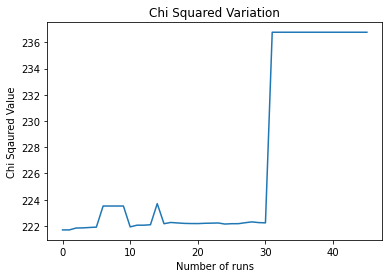

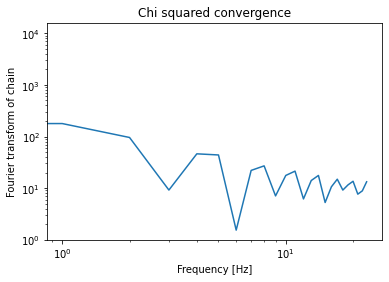

In [122]:
#chi_data = np.genfromtxt('chi_param_chain.txt', delimiter='\t', skip_header=1)
#chi = chi_data[:,0]
fft_chi = np.fft.rfft(chi)

# Plotting the actual chi sqaure values stored in txt file
plt.plot(chi)
plt.xlabel('Number of runs')
plt.ylabel('Chi Sqaured Value')
plt.title('Chi Squared Variation')
plt.show()

# Plotting the chi square value in Fourrier Space to verify convergence
plt.plot(np.abs(fft_chi))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Fourier transform of chain')
plt.title('Chi squared convergence')
plt.xscale('log')
plt.yscale('log')
plt.show()